### Imports

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score

### Data Loading

In [9]:
data = np.genfromtxt("/kaggle/input/wine-quality-dataset/WineQT.csv",
                 delimiter=",", dtype=str)

### Data Preprocessing

In [10]:
data

array([['fixed acidity', 'volatile acidity', 'citric acid', ...,
        'alcohol', 'quality', 'Id'],
       ['7.4', '0.7', '0.0', ..., '9.4', '5', '0'],
       ['7.8', '0.88', '0.0', ..., '9.8', '5', '1'],
       ...,
       ['6.2', '0.6', '0.08', ..., '10.5', '5', '1594'],
       ['5.9', '0.55', '0.1', ..., '11.2', '6', '1595'],
       ['5.9', '0.645', '0.12', ..., '10.2', '5', '1597']], dtype='<U20')

In [11]:
data = data[1:]
mask = np.random.choice([False, True], len(data), p=[0.80, 0.20])
train_data = data[np.invert(mask)].T[:-1]
test_data = data[mask].T[:-1]
X_test = test_data[:-1]
y_test = test_data[-1]
X_test = X_test.astype(np.float64)
y_test = y_test.astype(np.int64)
X_train, y_train = train_data[:-1], train_data[-1]
X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.int64)

In [12]:
for i in range(len(X_train)):
    mean = X_train[i].mean()
    std =  X_train[i].std()
    X_train[i] = (X_train[i] - mean) / std
    X_test[i] = (X_test[i] - mean) / std

In [13]:
temp1 = np.zeros([len(y_train), 10])
temp2 = np.zeros([len(y_test), 10])
for i in range(len(y_train)):
    temp1[i][y_train[i]] = 1
for i in range(len(y_test)):
    temp2[i][y_test[i]] = 1
y_train = temp1
y_test = temp2

### Model Implementation

In [14]:
class MLP:
    def __init__(self, inSize, hiddSize, outSize):
        self.inSize = inSize
        self.hiddSize = hiddSize
        self.outSize = outSize
        self.num_layers = len(hiddSize) + 1
        self.weights = []
        self.biases = []
        inLayer = inSize
        for laySize in hiddSize:
            rand1 = np.random.randn(inLayer, laySize)
            self.weights.append(rand1)
            rand2 = np.random.randn(laySize)
            self.biases.append(rand2)
            inLayer = laySize
        randw = np.random.randn(inLayer, outSize)
        self.weights.append(randw)
        randb = np.random.randn(outSize)
        self.biases.append(randb)

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        activation = X
        for i in range(self.num_layers):
            temp = np.dot(activation, self.weights[i]) + self.biases[i]
            activation = self.sigmoid(temp)
            self.z_values.append(temp)
            self.activations.append(activation)
        return activation

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def backward(self, X, y, learning_rate):
        num_samples = X.shape[0]
        d_weights = [np.zeros_like(w) for w in self.weights]
        d_biases = [np.zeros_like(b) for b in self.biases]
        delta = (self.activations[-1] - y) * self.sigmoid_derivative(self.z_values[-1])
        d_weights[-1] = np.dot(self.activations[-2].T, delta)
        d_biases[-1] = np.sum(delta, axis=0)
        for l in range(2, self.num_layers + 1):
            delta = np.dot(delta, self.weights[-l+1].T) * self.sigmoid_derivative(self.z_values[-l])
            d_weights[-l] = np.dot(self.activations[-l-1].T, delta)
            d_biases[-l] = np.sum(delta, axis=0)
        self.weights = [w - (learning_rate / num_samples) * dw for w, dw in zip(self.weights, d_weights)]
        self.biases = [b - (learning_rate / num_samples) * db for b, db in zip(self.biases, d_biases)]

    def train(self, X, y, learning_rate):
        output = self.forward(X)
        self.backward(X, y, learning_rate)
        
    def predict(self, X):
        return np.round(self.forward(X)).astype(np.int32)

In [15]:
def train_loop(model, epochs, learning_rate):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    y_true = None
    y_pred = None
    for epoch in range(epochs):
        model.train(X_train.T, y_train, learning_rate)
        if epoch % 100 == 0:
            nn_predictions_train = model.predict(X_train.T)
            train_loss = np.mean((nn_predictions_train - y_train) ** 2)
            y_true = np.zeros(len(y_train))
            for i in range(len(y_train)):
                for j in range(len(y_train[0])):
                    if y_train[i][j] == 1:
                        y_true[i] = j
            y_pred = np.zeros(len(nn_predictions_train))
            for i in range(len(nn_predictions_train)):
                for j in range(len(nn_predictions_train[0])):
                    if nn_predictions_train[i][j] == 1:
                        y_pred[i] = j
            train_accuracy = np.sum((y_true == y_pred)) / y_train.shape[0]
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            nn_predictions_test = model.predict(X_test.T)
            test_loss = np.mean((nn_predictions_test - y_test) ** 2)
            y_true = np.zeros(len(y_test))
            for i in range(len(y_test)):
                for j in range(len(y_test[0])):
                    if y_test[i][j] == 1:
                        y_true[i] = j
            y_pred = np.zeros(len(nn_predictions_test))
            for i in range(len(nn_predictions_test)):
                for j in range(len(nn_predictions_test[0])):
                    if nn_predictions_test[i][j] == 1:
                        y_pred[i] = j
            test_accuracy = np.sum((y_true == y_pred)) / y_test.shape[0]
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)
            if epoch % 1000 == 0:          
                print(f"Epoch {epoch}: Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}, Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")
    return train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred

In [16]:
from sklearn.metrics import confusion_matrix
def plot_results(train_losses, train_accuracies, test_losses, test_accuracies, y_true, predicted_labels):
    plt.figure(figsize=(15, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs, 100), train_losses, label='Train', color='purple')
    plt.plot(range(0, epochs, 100), test_losses, label='Test', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs, 100), train_accuracies, label='Train', color='red')
    plt.plot(range(0, epochs, 100), test_accuracies, label='Test', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    conf_matrix = confusion_matrix(y_true, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Epoch 0: Train Loss: 0.30, Train Accuracy: 0.13, Test Loss: 0.31, Test Accuracy: 0.12
Epoch 1000: Train Loss: 0.30, Train Accuracy: 0.13, Test Loss: 0.31, Test Accuracy: 0.12
Epoch 2000: Train Loss: 0.30, Train Accuracy: 0.13, Test Loss: 0.31, Test Accuracy: 0.12
Epoch 3000: Train Loss: 0.30, Train Accuracy: 0.13, Test Loss: 0.31, Test Accuracy: 0.12
Learning rate: 1e-08
Accuracy: 0.0269
Classification Report:
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.00      0.00      0.00        83
         6.0       0.00      0.00      0.00        89
         7.0       0.12      1.00      0.21        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.12       214
   macro avg       0.02      0.17      0.03       214
weighted avg       0.01      0.12      0.02       214



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


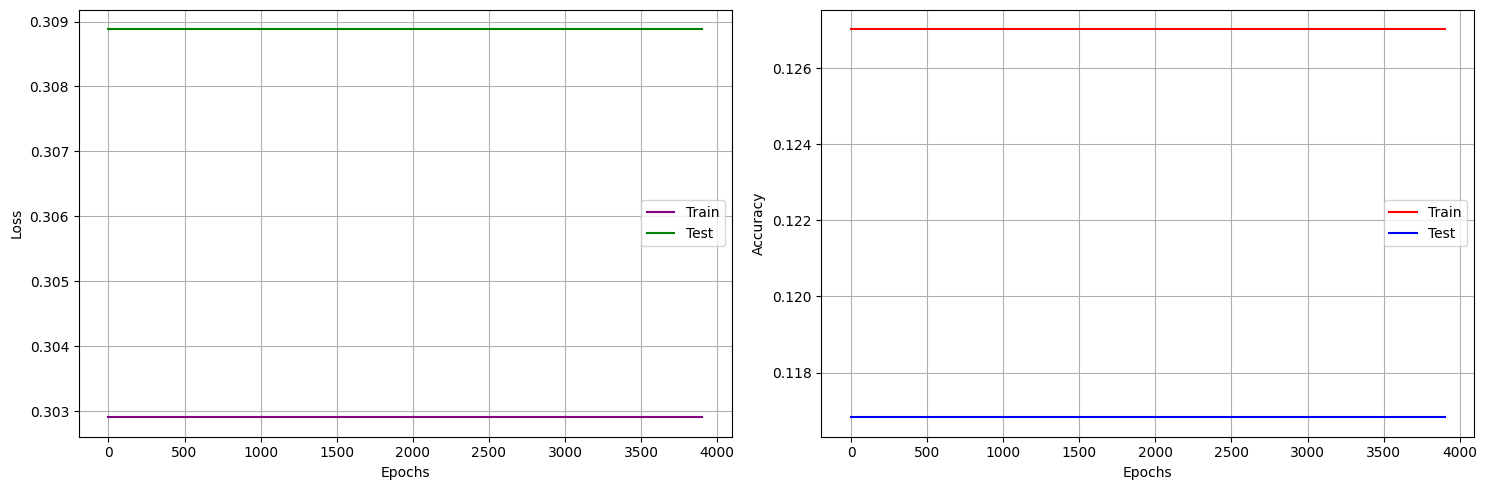

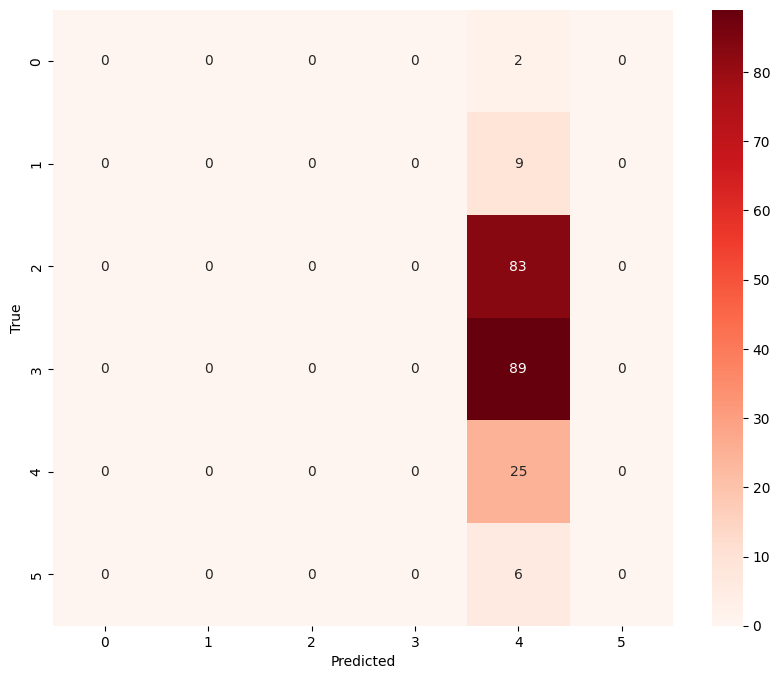

Epoch 0: Train Loss: 0.47, Train Accuracy: 0.01, Test Loss: 0.47, Test Accuracy: 0.03
Epoch 1000: Train Loss: 0.47, Train Accuracy: 0.01, Test Loss: 0.47, Test Accuracy: 0.03
Epoch 2000: Train Loss: 0.47, Train Accuracy: 0.01, Test Loss: 0.47, Test Accuracy: 0.03
Epoch 3000: Train Loss: 0.47, Train Accuracy: 0.01, Test Loss: 0.47, Test Accuracy: 0.03
Learning rate: 4e-08
Accuracy: 0.0065
Classification Report:
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.00      0.00      0.00        83
         6.0       0.00      0.00      0.00        89
         7.0       0.00      0.00      0.00        25
         8.0       0.03      1.00      0.06         6

    accuracy                           0.03       214
   macro avg       0.00      0.17      0.01       214
weighted avg       0.00      0.03      0.00       214



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


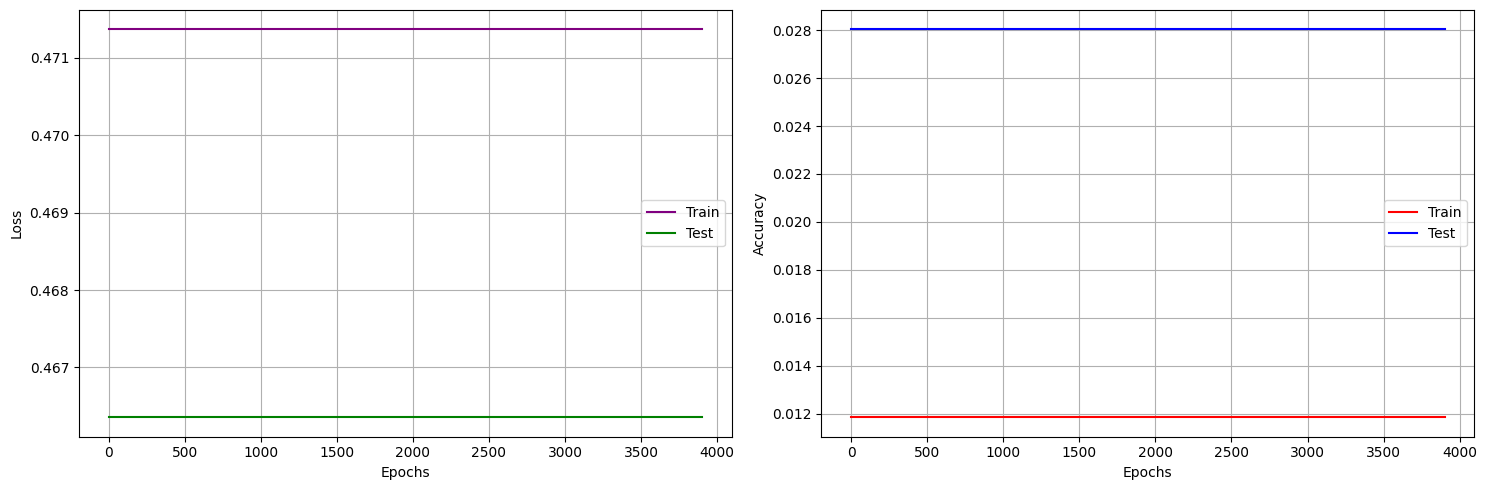

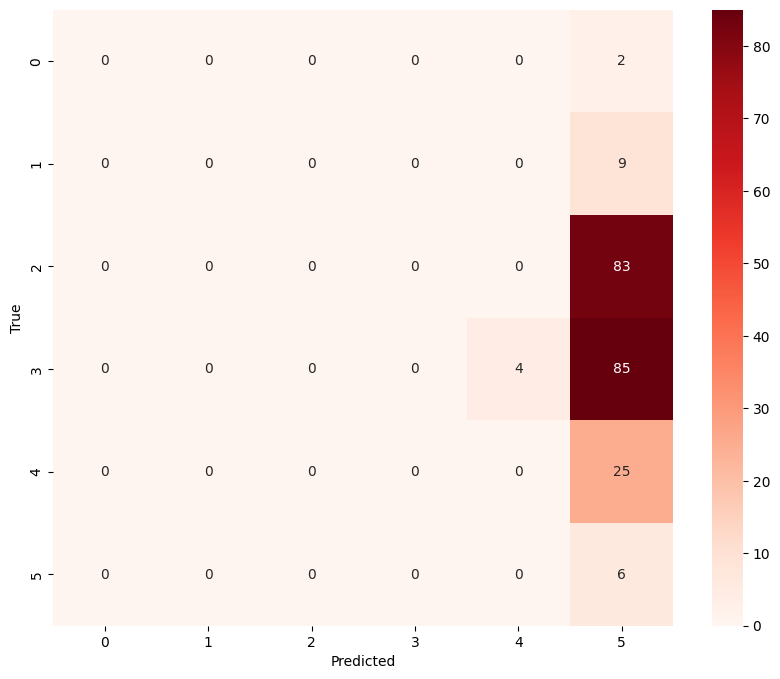

Epoch 0: Train Loss: 0.59, Train Accuracy: 0.00, Test Loss: 0.59, Test Accuracy: 0.00
Epoch 1000: Train Loss: 0.59, Train Accuracy: 0.00, Test Loss: 0.59, Test Accuracy: 0.00
Epoch 2000: Train Loss: 0.59, Train Accuracy: 0.00, Test Loss: 0.59, Test Accuracy: 0.00
Epoch 3000: Train Loss: 0.59, Train Accuracy: 0.00, Test Loss: 0.59, Test Accuracy: 0.00
Learning rate: 1.6e-07
Accuracy: 0.0000
Classification Report:
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00       2.0
         4.0       0.00      0.00      0.00       9.0
         5.0       0.00      0.00      0.00      83.0
         6.0       0.00      0.00      0.00      89.0
         7.0       0.00      0.00      0.00      25.0
         8.0       0.00      0.00      0.00       6.0
         9.0       0.00      0.00      0.00       0.0

    accuracy                           0.00     214.0
   macro avg       0.00      0.00      0.00     214.0
weighted avg       0.00      0.00      0.0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

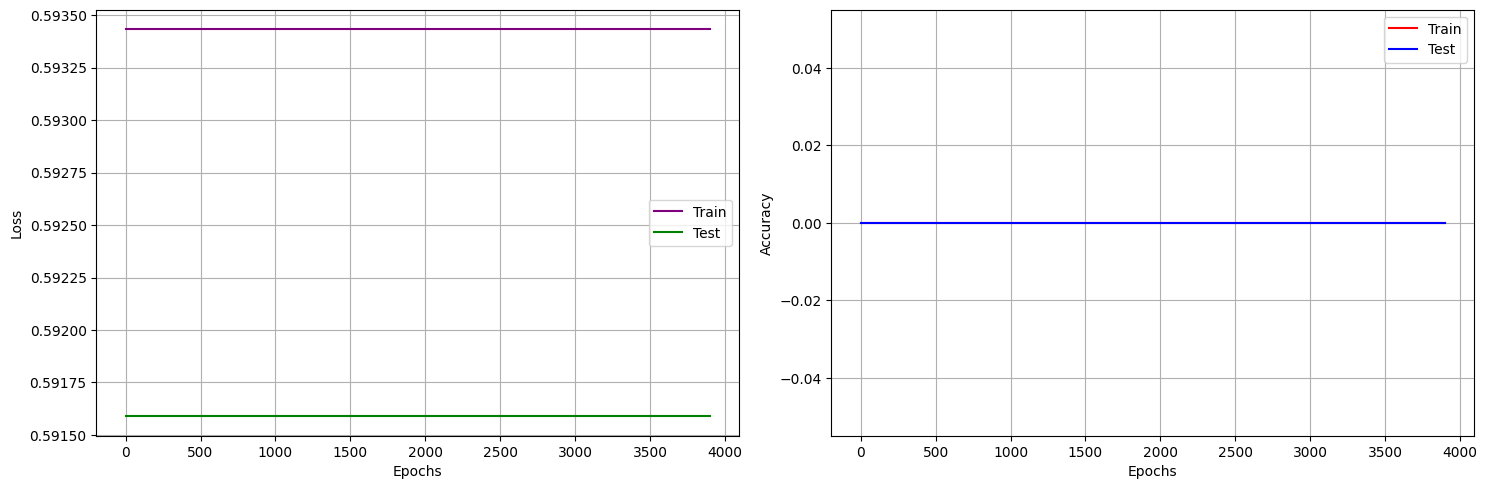

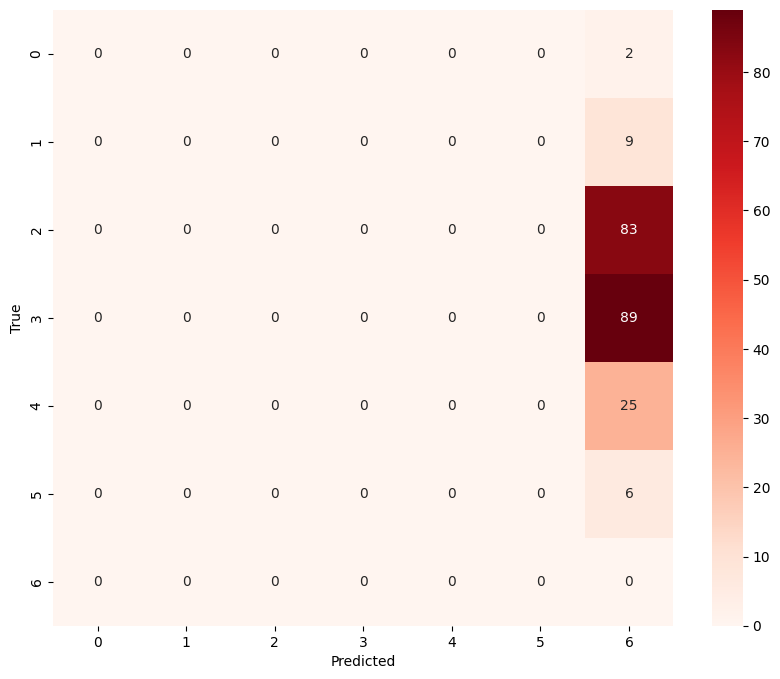

Epoch 0: Train Loss: 0.24, Train Accuracy: 0.13, Test Loss: 0.24, Test Accuracy: 0.12
Epoch 1000: Train Loss: 0.24, Train Accuracy: 0.13, Test Loss: 0.24, Test Accuracy: 0.12
Epoch 2000: Train Loss: 0.24, Train Accuracy: 0.13, Test Loss: 0.24, Test Accuracy: 0.12
Epoch 3000: Train Loss: 0.24, Train Accuracy: 0.13, Test Loss: 0.24, Test Accuracy: 0.12
Learning rate: 6.4e-07
Accuracy: 0.0269
Classification Report:
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.00      0.00      0.00        83
         6.0       0.00      0.00      0.00        89
         7.0       0.12      1.00      0.21        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.12       214
   macro avg       0.02      0.17      0.03       214
weighted avg       0.01      0.12      0.02       214



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


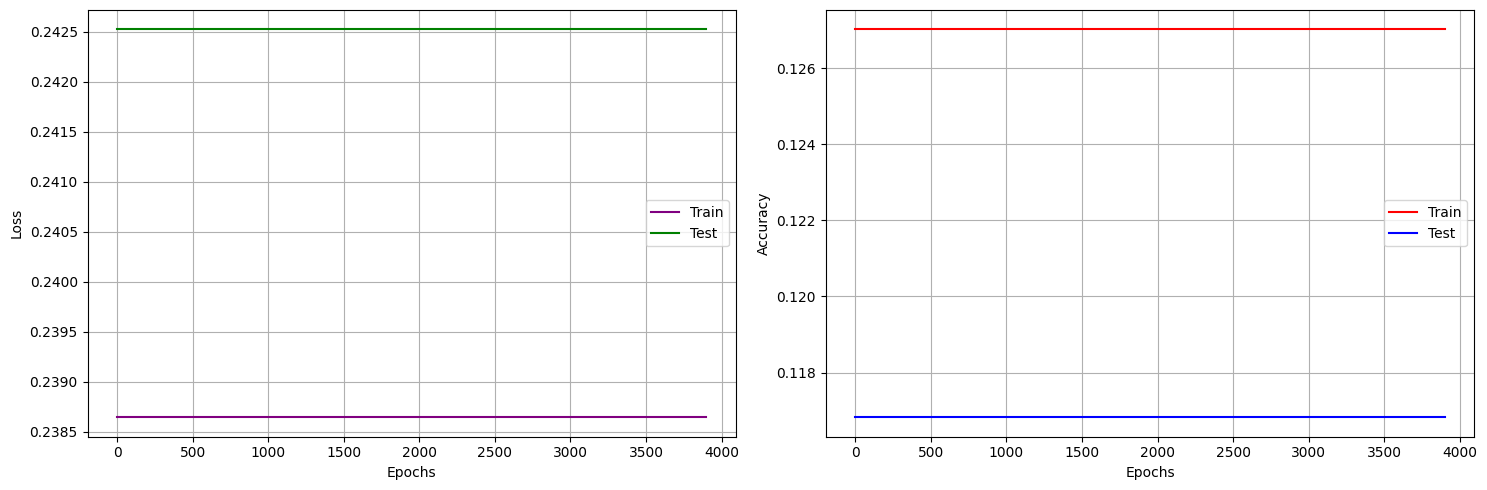

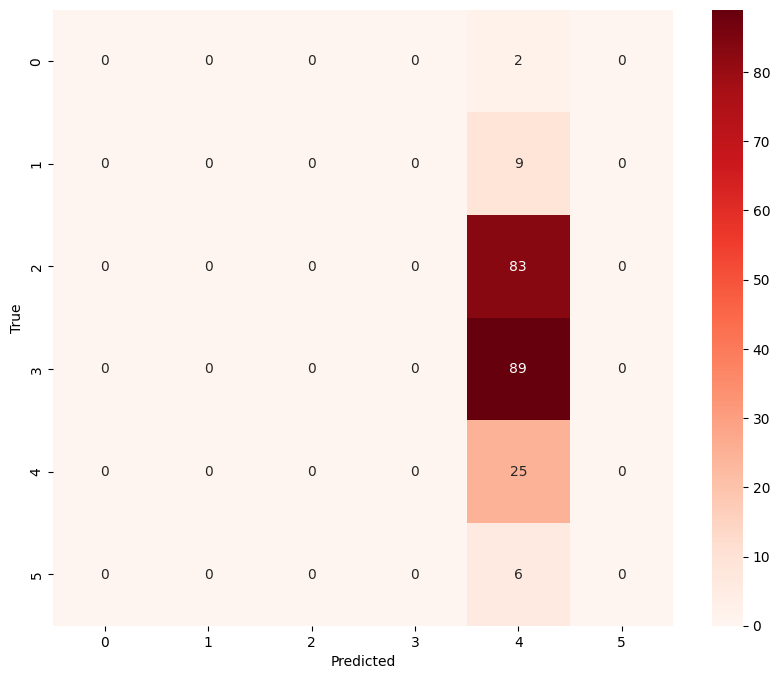

Epoch 0: Train Loss: 0.73, Train Accuracy: 0.00, Test Loss: 0.73, Test Accuracy: 0.00
Epoch 1000: Train Loss: 0.73, Train Accuracy: 0.00, Test Loss: 0.73, Test Accuracy: 0.00
Epoch 2000: Train Loss: 0.73, Train Accuracy: 0.00, Test Loss: 0.73, Test Accuracy: 0.00
Epoch 3000: Train Loss: 0.73, Train Accuracy: 0.00, Test Loss: 0.73, Test Accuracy: 0.00
Learning rate: 2.56e-06
Accuracy: 0.0000
Classification Report:
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00       2.0
         4.0       0.00      0.00      0.00       9.0
         5.0       0.00      0.00      0.00      83.0
         6.0       0.00      0.00      0.00      89.0
         7.0       0.00      0.00      0.00      25.0
         8.0       0.00      0.00      0.00       6.0
         9.0       0.00      0.00      0.00       0.0

    accuracy                           0.00     214.0
   macro avg       0.00      0.00      0.00     214.0
weighted avg       0.00      0.00      0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

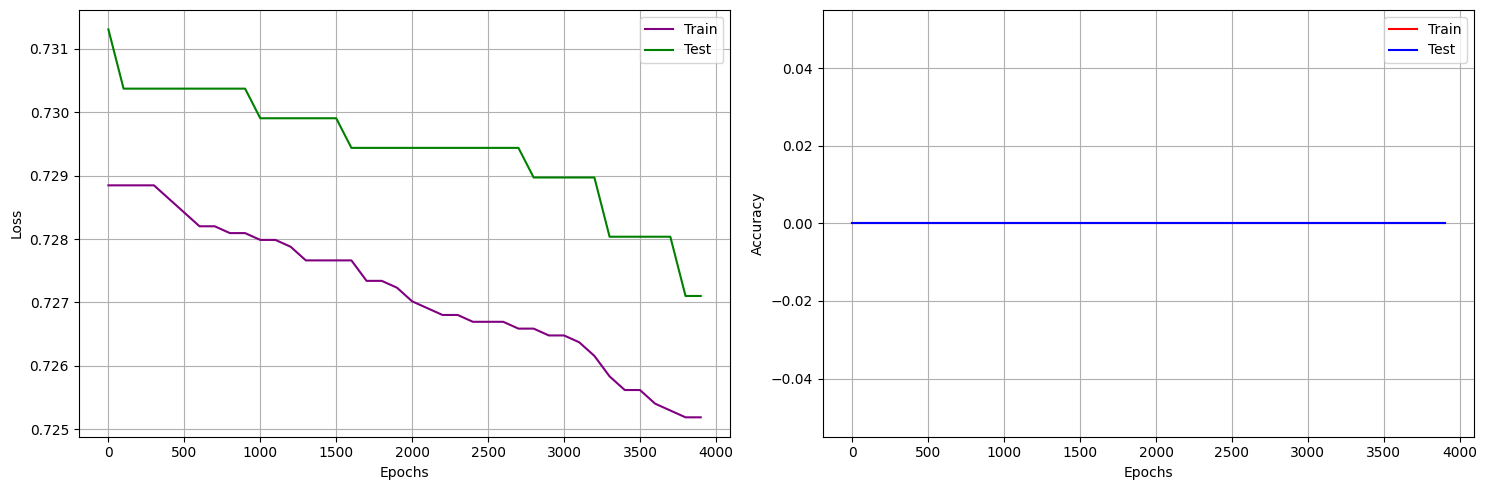

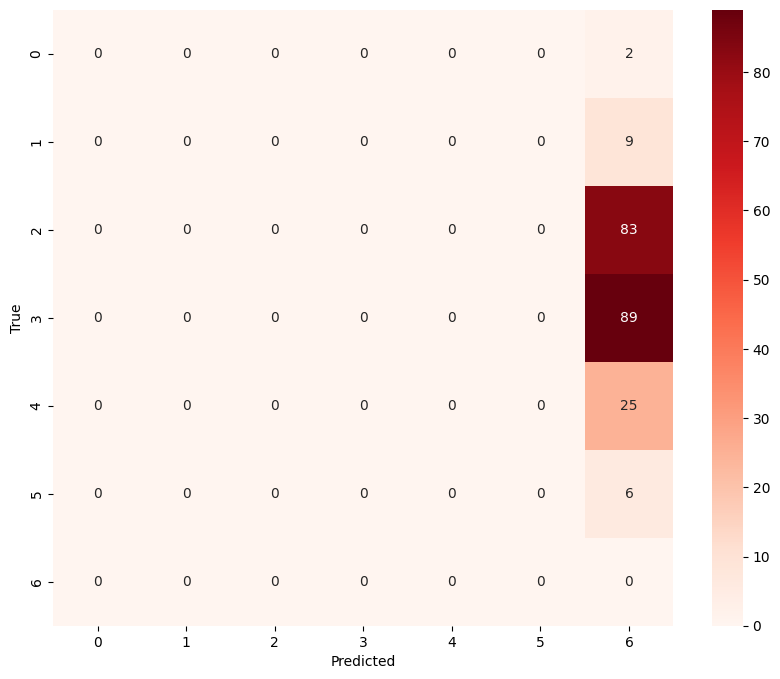

Epoch 0: Train Loss: 0.46, Train Accuracy: 0.03, Test Loss: 0.46, Test Accuracy: 0.03
Epoch 1000: Train Loss: 0.46, Train Accuracy: 0.03, Test Loss: 0.46, Test Accuracy: 0.04
Epoch 2000: Train Loss: 0.45, Train Accuracy: 0.03, Test Loss: 0.46, Test Accuracy: 0.04
Epoch 3000: Train Loss: 0.45, Train Accuracy: 0.03, Test Loss: 0.46, Test Accuracy: 0.04
Learning rate: 1.024e-05
Accuracy: 0.0097
Classification Report:
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.00      0.00      0.00        83
         6.0       0.00      0.00      0.00        89
         7.0       0.03      0.12      0.04        25
         8.0       0.06      1.00      0.11         6

    accuracy                           0.04       214
   macro avg       0.01      0.19      0.03       214
weighted avg       0.00      0.04      0.01       214



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


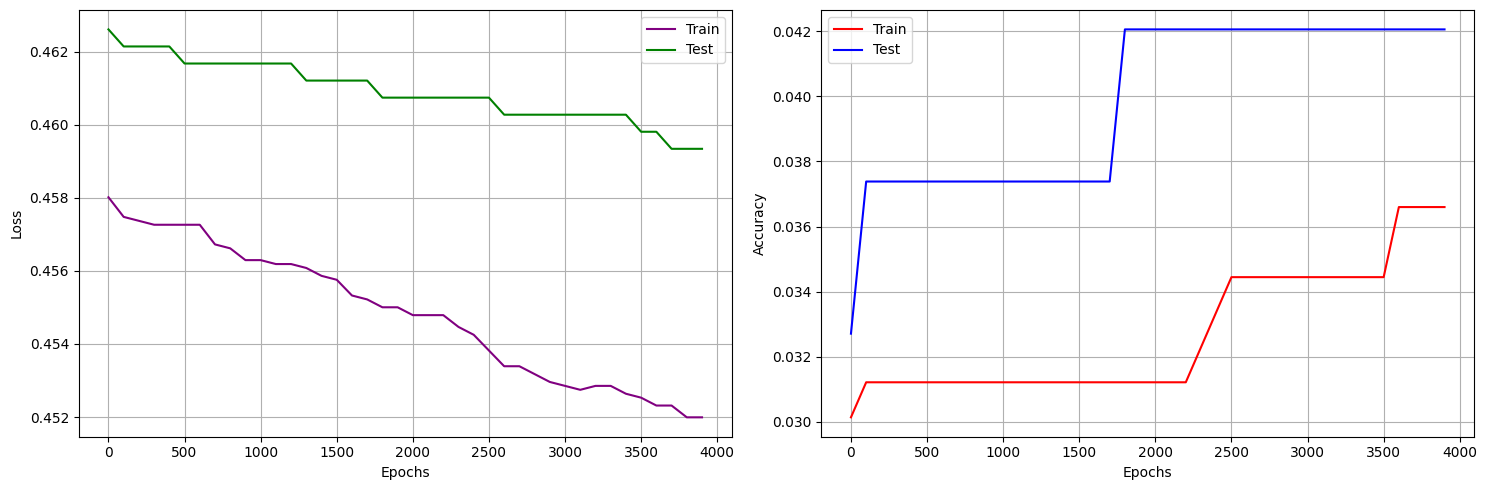

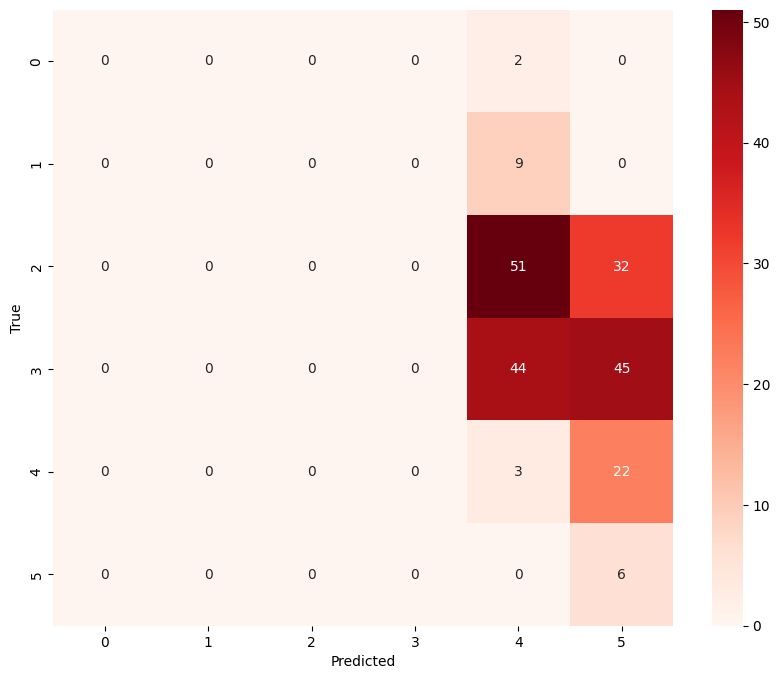

Epoch 0: Train Loss: 0.44, Train Accuracy: 0.01, Test Loss: 0.44, Test Accuracy: 0.02
Epoch 1000: Train Loss: 0.43, Train Accuracy: 0.01, Test Loss: 0.43, Test Accuracy: 0.02
Epoch 2000: Train Loss: 0.43, Train Accuracy: 0.01, Test Loss: 0.43, Test Accuracy: 0.02
Epoch 3000: Train Loss: 0.43, Train Accuracy: 0.01, Test Loss: 0.43, Test Accuracy: 0.02
Learning rate: 4.096e-05
Accuracy: 0.0054
Classification Report:
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.00      0.00      0.00        83
         6.0       0.00      0.00      0.00        89
         7.0       0.00      0.00      0.00        25
         8.0       0.03      0.83      0.05         6
         9.0       0.00      0.00      0.00         0

    accuracy                           0.02       214
   macro avg       0.00      0.12      0.01       214
weighted avg       0.00      0.02      0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

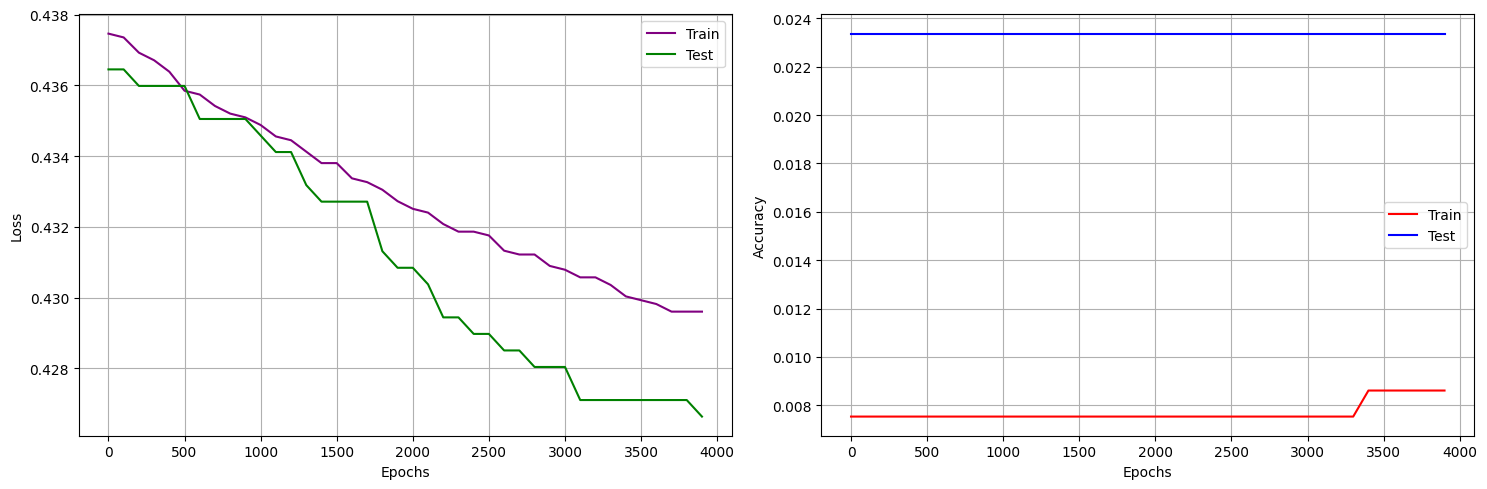

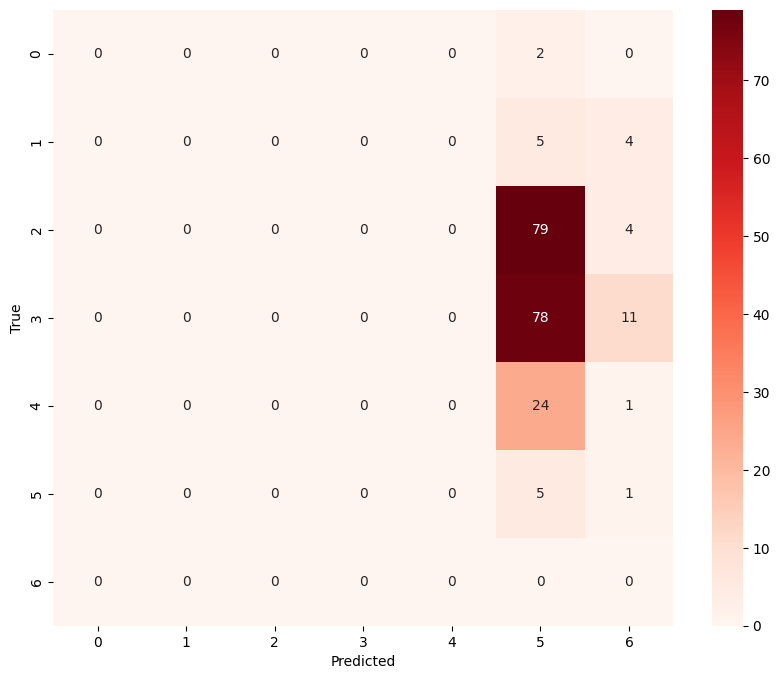

Epoch 0: Train Loss: 0.57, Train Accuracy: 0.01, Test Loss: 0.57, Test Accuracy: 0.01
Epoch 1000: Train Loss: 0.51, Train Accuracy: 0.01, Test Loss: 0.52, Test Accuracy: 0.02
Epoch 2000: Train Loss: 0.48, Train Accuracy: 0.01, Test Loss: 0.49, Test Accuracy: 0.03
Epoch 3000: Train Loss: 0.44, Train Accuracy: 0.01, Test Loss: 0.45, Test Accuracy: 0.03
Learning rate: 0.00016384
Accuracy: 0.0065
Classification Report:
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.00      0.00      0.00        83
         6.0       0.00      0.00      0.00        89
         7.0       0.00      0.00      0.00        25
         8.0       0.03      1.00      0.05         6

    accuracy                           0.03       214
   macro avg       0.00      0.17      0.01       214
weighted avg       0.00      0.03      0.00       214



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


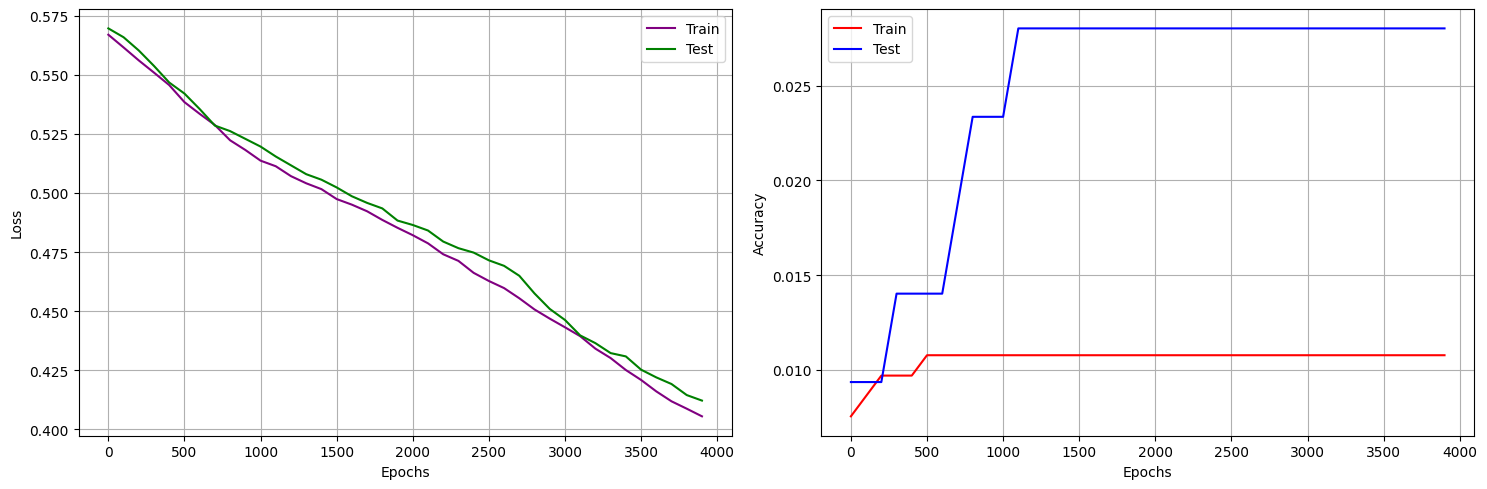

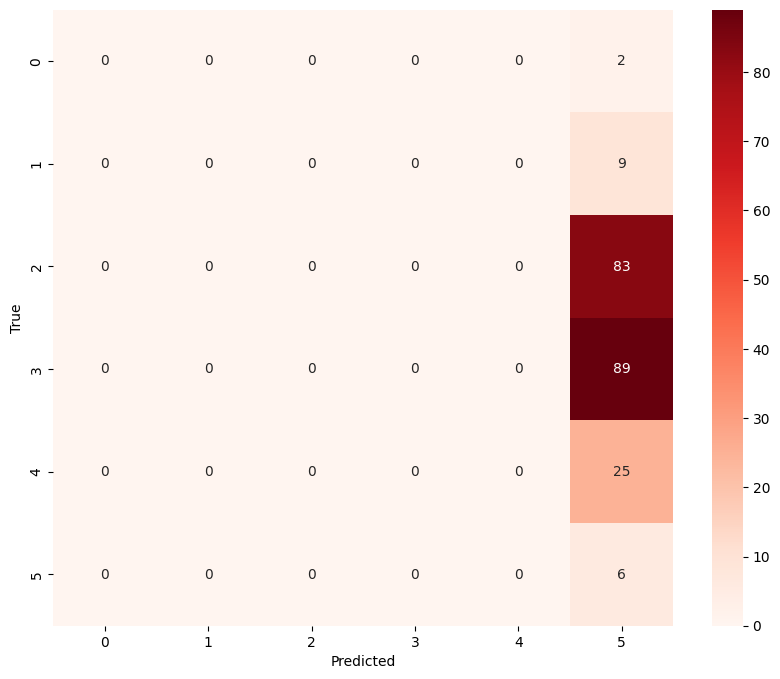

Epoch 0: Train Loss: 0.75, Train Accuracy: 0.00, Test Loss: 0.77, Test Accuracy: 0.00
Epoch 1000: Train Loss: 0.57, Train Accuracy: 0.01, Test Loss: 0.58, Test Accuracy: 0.03
Epoch 2000: Train Loss: 0.41, Train Accuracy: 0.09, Test Loss: 0.41, Test Accuracy: 0.08
Epoch 3000: Train Loss: 0.39, Train Accuracy: 0.13, Test Loss: 0.40, Test Accuracy: 0.12
Learning rate: 0.00065536
Accuracy: 0.0861
Classification Report:
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.40      0.94      0.56        83
         6.0       0.00      0.00      0.00        89
         7.0       0.10      0.08      0.09        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.37       214
   macro avg       0.08      0.17      0.11       214
weighted avg       0.17      0.37      0.23       214



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


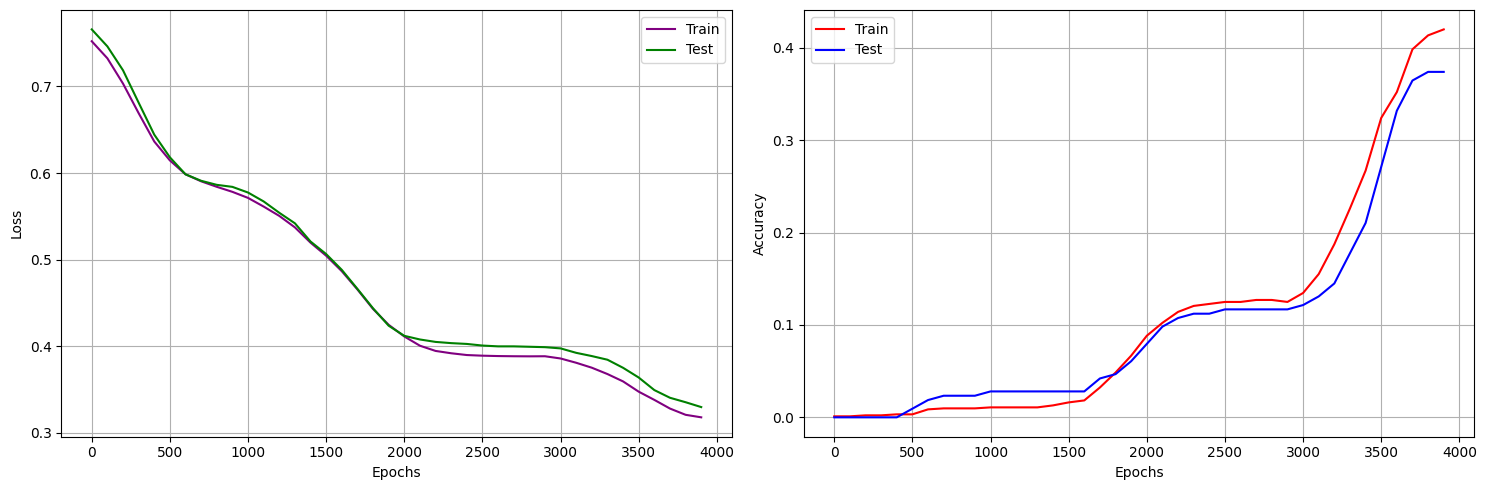

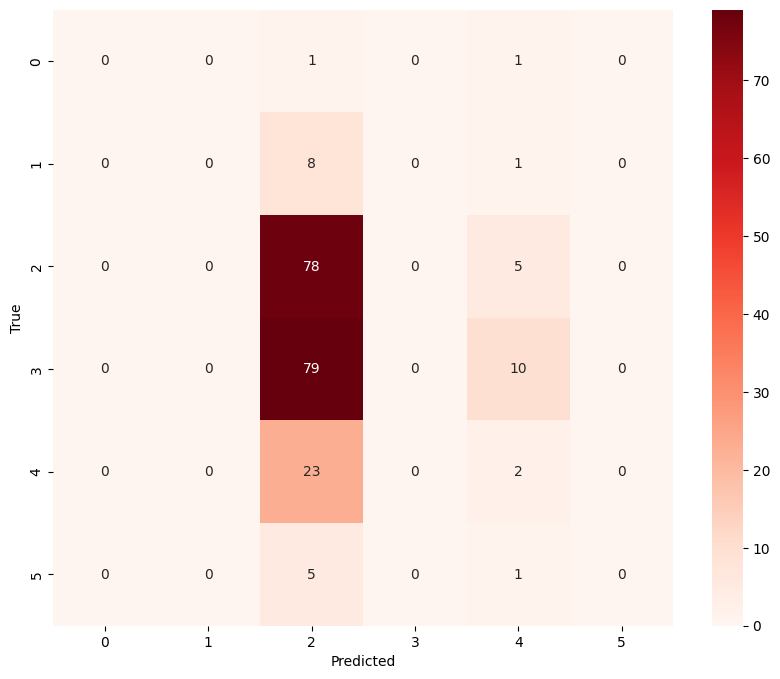

Epoch 0: Train Loss: 0.60, Train Accuracy: 0.06, Test Loss: 0.60, Test Accuracy: 0.06
Epoch 1000: Train Loss: 0.15, Train Accuracy: 0.42, Test Loss: 0.16, Test Accuracy: 0.37
Epoch 2000: Train Loss: 0.11, Train Accuracy: 0.43, Test Loss: 0.12, Test Accuracy: 0.39
Epoch 3000: Train Loss: 0.11, Train Accuracy: 0.43, Test Loss: 0.12, Test Accuracy: 0.38
Learning rate: 0.00262144
Accuracy: 0.0872
Classification Report:
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.38      0.95      0.54        83
         6.0       0.33      0.02      0.04        89
         7.0       0.00      0.00      0.00        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.38       214
   macro avg       0.12      0.16      0.10       214
weighted avg       0.29      0.38      0.23       214



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


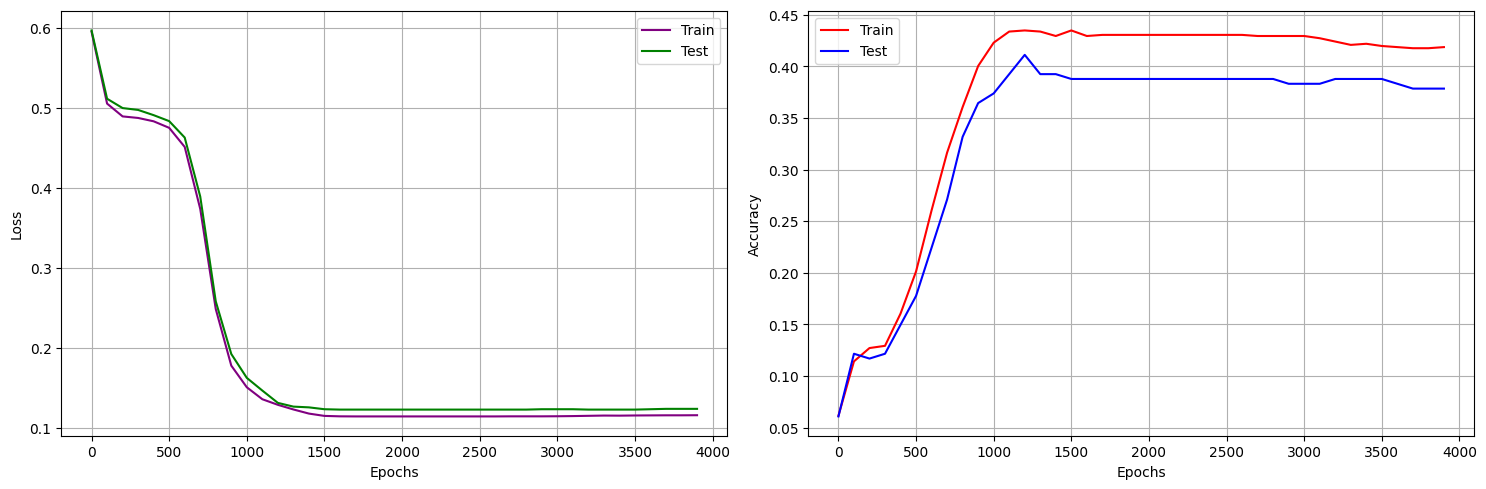

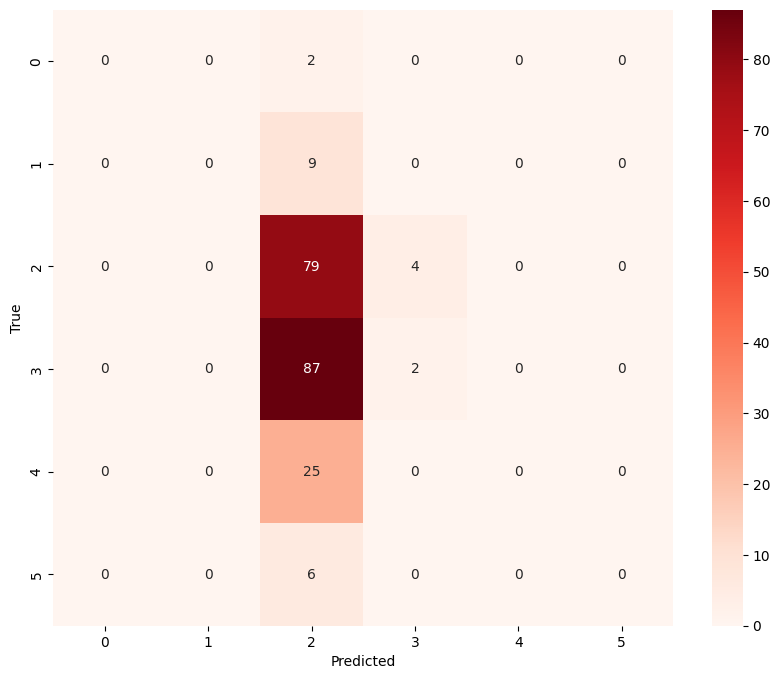

Epoch 0: Train Loss: 0.46, Train Accuracy: 0.00, Test Loss: 0.45, Test Accuracy: 0.00
Epoch 1000: Train Loss: 0.10, Train Accuracy: 0.04, Test Loss: 0.11, Test Accuracy: 0.02
Epoch 2000: Train Loss: 0.10, Train Accuracy: 0.04, Test Loss: 0.10, Test Accuracy: 0.02
Epoch 3000: Train Loss: 0.10, Train Accuracy: 0.04, Test Loss: 0.10, Test Accuracy: 0.02
Learning rate: 0.01048576
Accuracy: 0.0054
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.17      0.01      0.02        83
         6.0       0.29      0.04      0.08        89
         7.0       0.00      0.00      0.00        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.02       214
   macro avg       0.06      0.01      0.01       214
weighted avg       0.18      0.02      

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

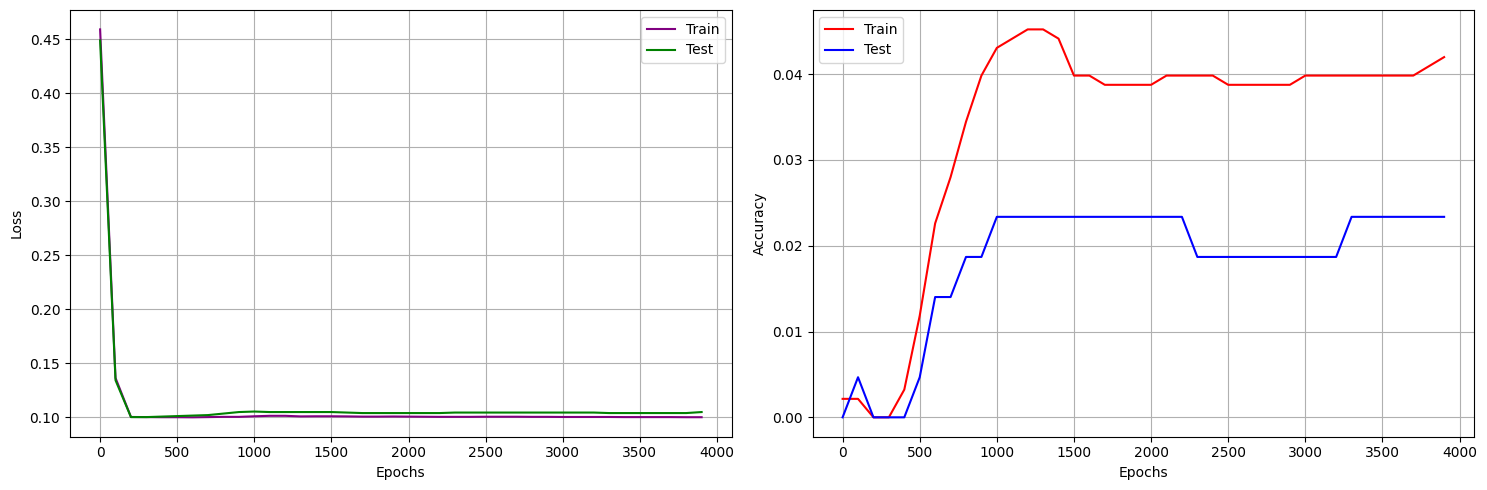

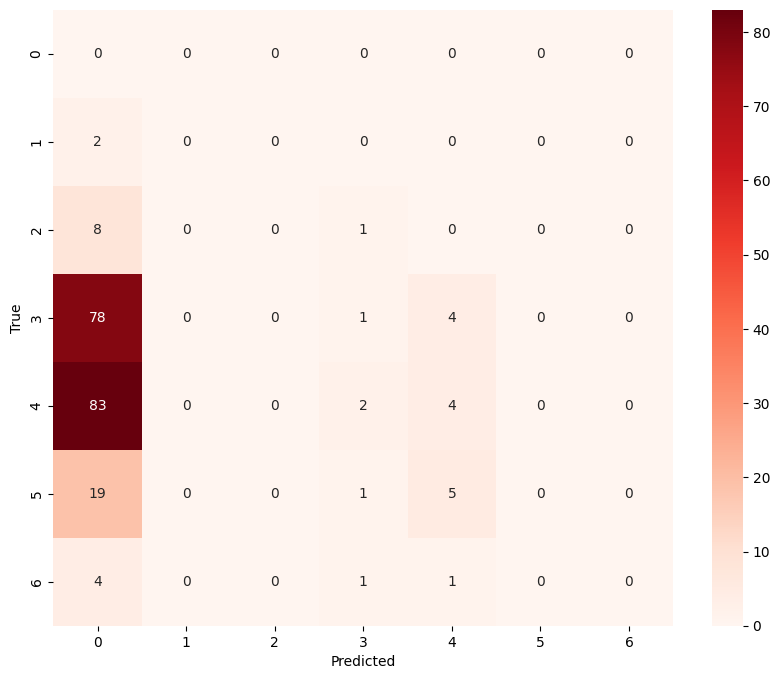

Epoch 0: Train Loss: 0.48, Train Accuracy: 0.00, Test Loss: 0.47, Test Accuracy: 0.00
Epoch 1000: Train Loss: 0.10, Train Accuracy: 0.08, Test Loss: 0.10, Test Accuracy: 0.07
Epoch 2000: Train Loss: 0.09, Train Accuracy: 0.17, Test Loss: 0.10, Test Accuracy: 0.14
Epoch 3000: Train Loss: 0.09, Train Accuracy: 0.28, Test Loss: 0.09, Test Accuracy: 0.25
Learning rate: 0.04194304
Accuracy: 0.0710
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.58      0.64      0.61        83
         6.0       0.37      0.15      0.21        89
         7.0       0.00      0.00      0.00        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.31       214
   macro avg       0.14      0.11      0.12       214
weighted avg       0.38      0.31      

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

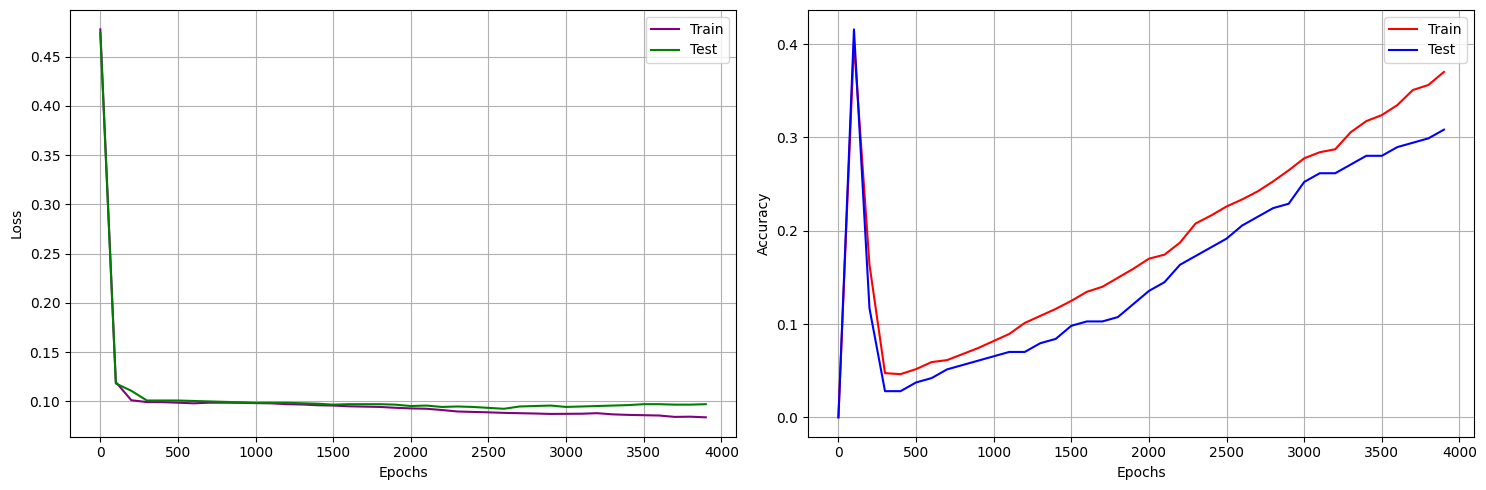

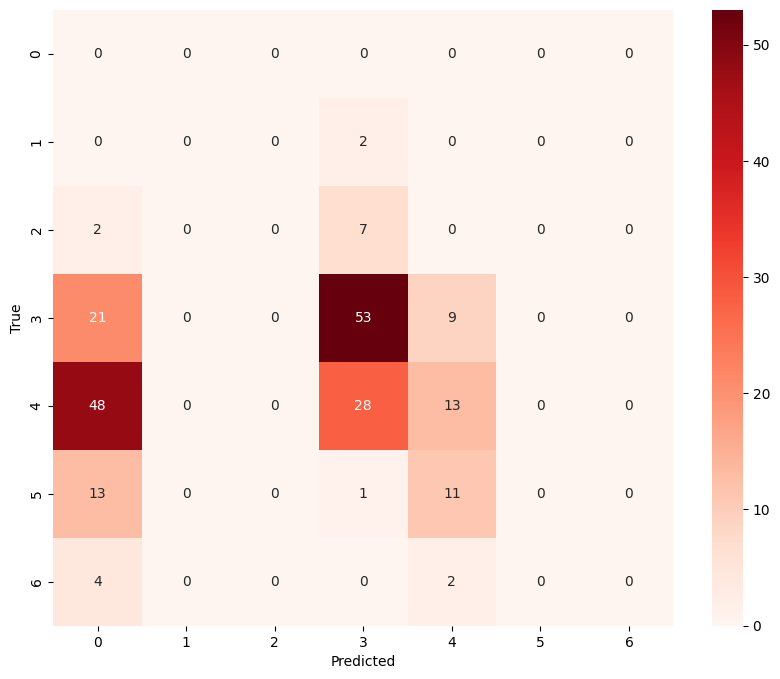

Epoch 0: Train Loss: 0.53, Train Accuracy: 0.00, Test Loss: 0.53, Test Accuracy: 0.00
Epoch 1000: Train Loss: 0.08, Train Accuracy: 0.38, Test Loss: 0.09, Test Accuracy: 0.37
Epoch 2000: Train Loss: 0.08, Train Accuracy: 0.53, Test Loss: 0.09, Test Accuracy: 0.44
Epoch 3000: Train Loss: 0.07, Train Accuracy: 0.55, Test Loss: 0.09, Test Accuracy: 0.48
Learning rate: 0.16777216
Accuracy: 0.1098
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.58      0.67      0.62        83
         6.0       0.54      0.52      0.53        89
         7.0       0.00      0.00      0.00        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.48       214
   macro avg       0.16      0.17      0.16       214
weighted avg       0.45      0.48      

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

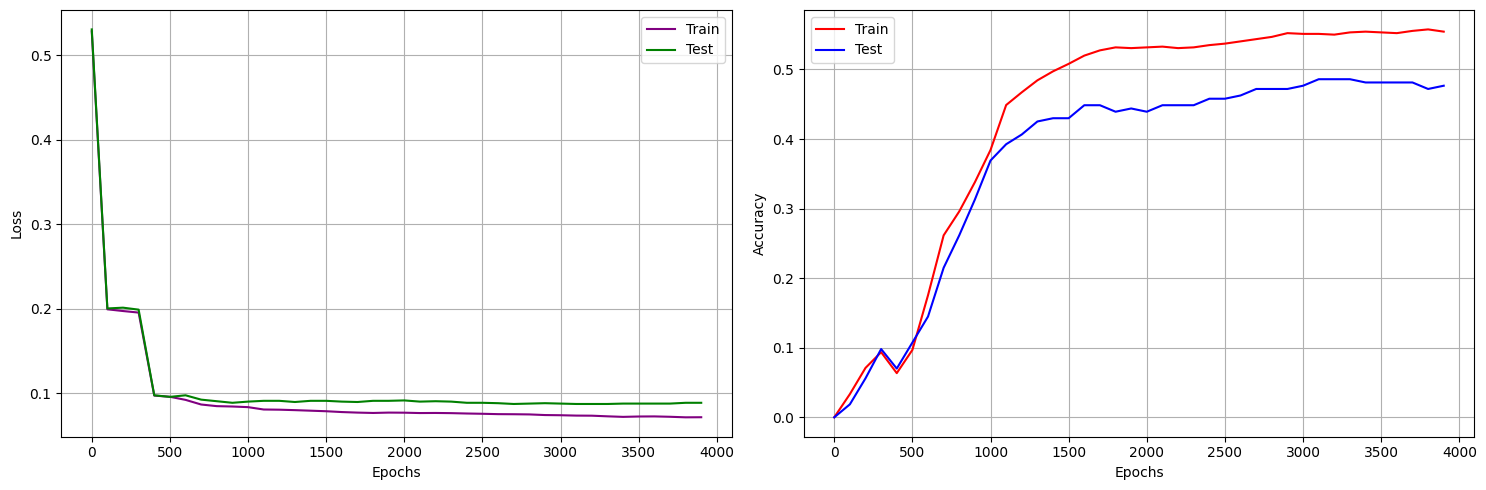

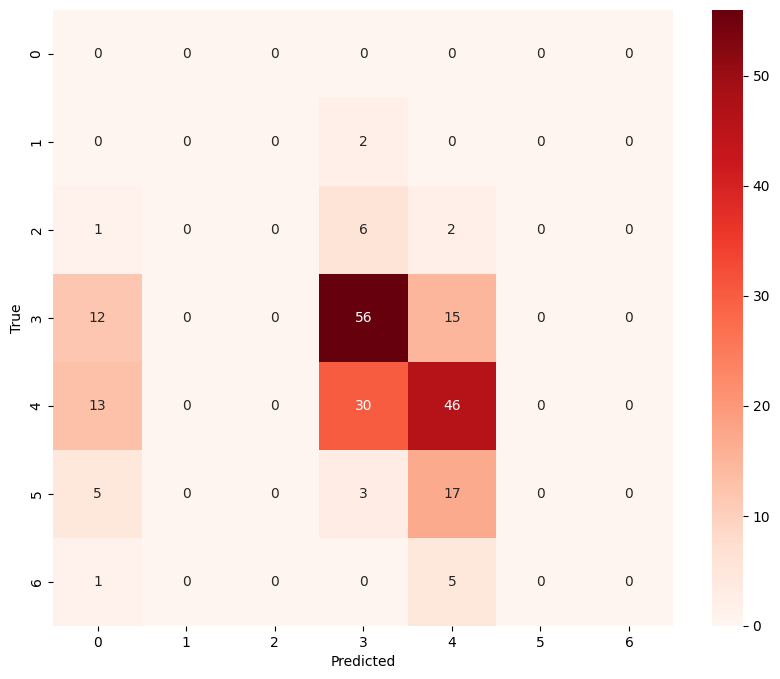

Epoch 0: Train Loss: 0.49, Train Accuracy: 0.01, Test Loss: 0.48, Test Accuracy: 0.03
Epoch 1000: Train Loss: 0.07, Train Accuracy: 0.52, Test Loss: 0.09, Test Accuracy: 0.45
Epoch 2000: Train Loss: 0.06, Train Accuracy: 0.62, Test Loss: 0.09, Test Accuracy: 0.46
Epoch 3000: Train Loss: 0.05, Train Accuracy: 0.69, Test Loss: 0.09, Test Accuracy: 0.46
Learning rate: 0.67108864
Accuracy: 0.1055
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.58      0.64      0.61        83
         6.0       0.49      0.38      0.43        89
         7.0       0.44      0.44      0.44        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.46       214
   macro avg       0.22      0.21      0.21       214
weighted avg       0.48      0.46      

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

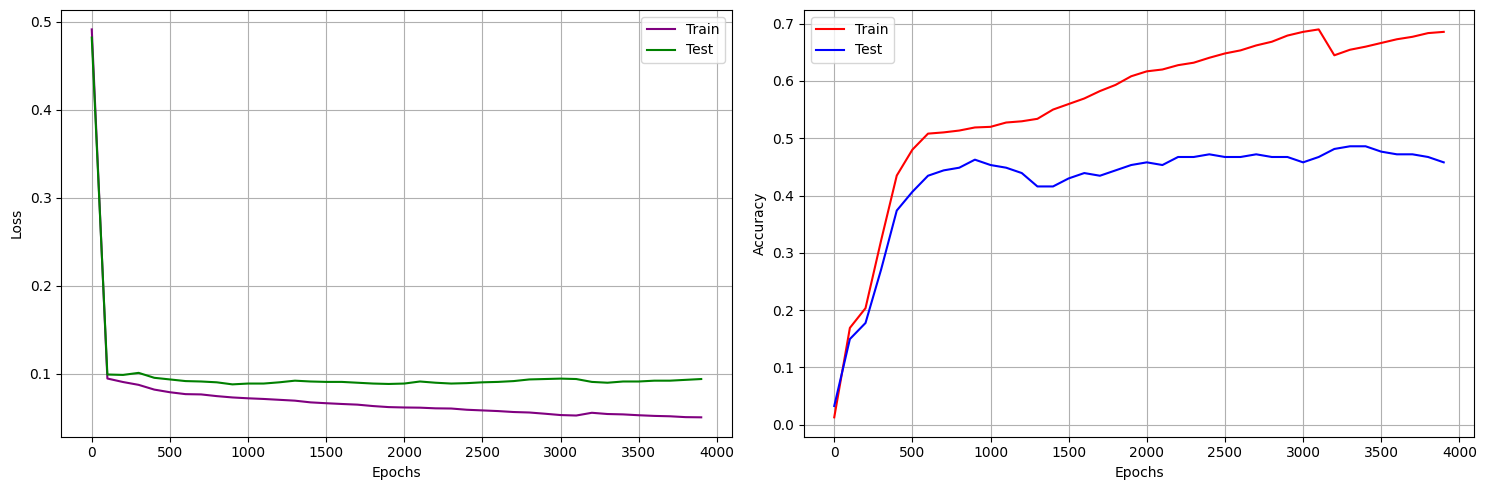

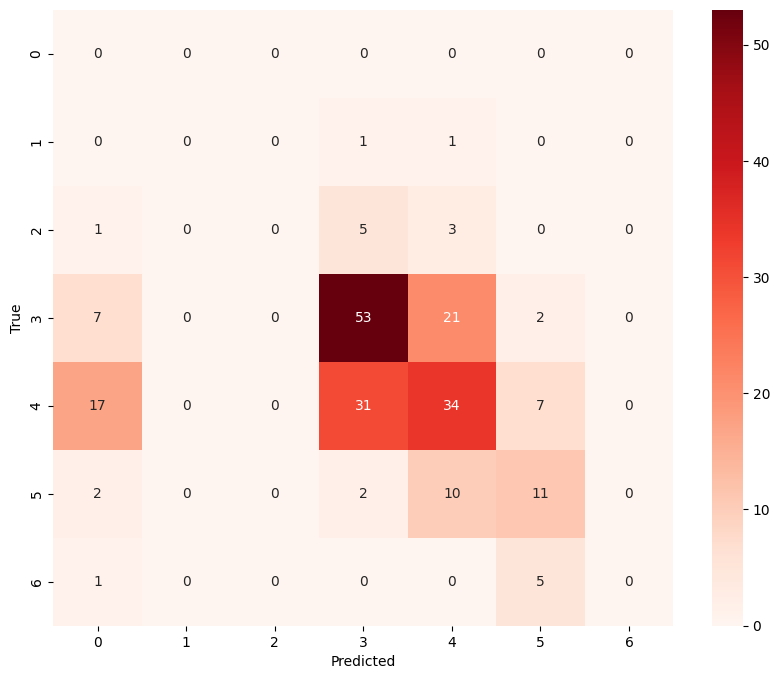

Epoch 0: Train Loss: 0.50, Train Accuracy: 0.00, Test Loss: 0.51, Test Accuracy: 0.00
Epoch 1000: Train Loss: 0.05, Train Accuracy: 0.71, Test Loss: 0.09, Test Accuracy: 0.48
Epoch 2000: Train Loss: 0.04, Train Accuracy: 0.75, Test Loss: 0.09, Test Accuracy: 0.53
Epoch 3000: Train Loss: 0.03, Train Accuracy: 0.83, Test Loss: 0.09, Test Accuracy: 0.56
Learning rate: 2.68435456
Accuracy: 0.1249
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.62      0.66      0.64        83
         6.0       0.55      0.49      0.52        89
         7.0       0.45      0.68      0.54        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.54       214
   macro avg       0.23      0.26      0.24       214
weighted avg       0.52      0.54      

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

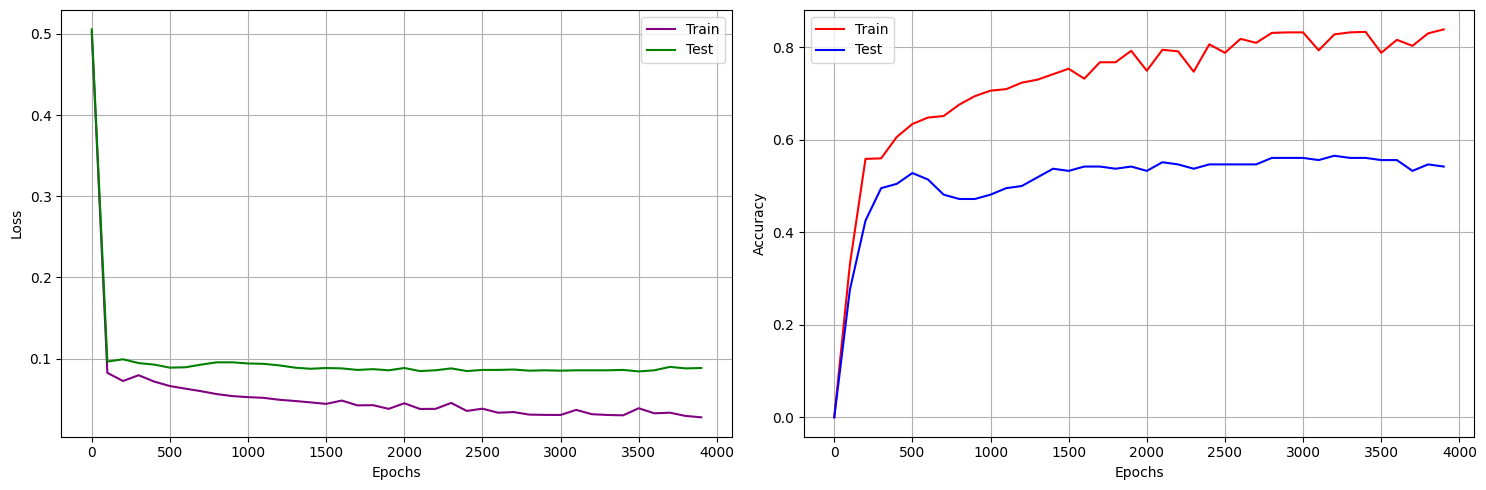

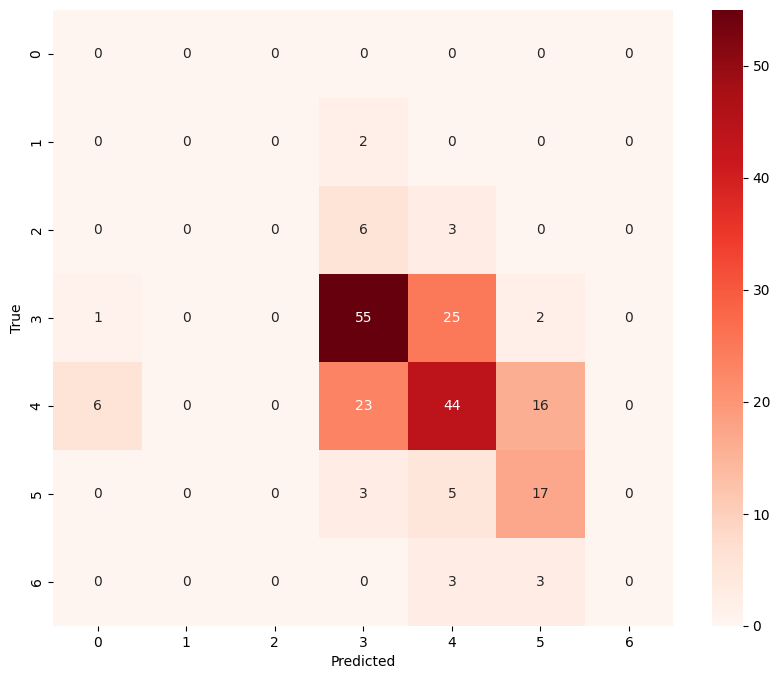

In [17]:
from sklearn.metrics import classification_report
learning_rate = 0.00000001
for i in range(15):
    nn = MLP(11,[15, 30, 30, 15] , 10)
    epochs = 4000
    train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred = train_loop(nn, epochs, learning_rate)
    print(f'Learning rate: {learning_rate}')
    accuracy = np.sum((y_true == y_pred)) / y_train.shape[0]
    print(f'Accuracy: {accuracy:.4f}')

    class_report = classification_report(y_true, y_pred)
    print('Classification Report:')
    print(class_report)
    plot_results(train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred)
    learning_rate *= 4

In [21]:

class MLP_tanh:
    def __init__(self, input_size, hidden_layer_sizes, output_size):
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_layer_sizes) + 1
        self.weights = []
        self.biases = []
        input_layer_size = input_size
        for layer_size in hidden_layer_sizes:
            rand1 = np.random.randn(input_layer_size, layer_size) / 10
            self.weights.append(rand1)
            rand2 = np.random.randn(layer_size) / 10
            self.biases.append(rand2)
            input_layer_size = layer_size
        randw = np.random.randn(input_layer_size, output_size) / 10
        self.weights.append(randw)
        randb = np.random.randn(output_size) / 10
        self.biases.append(randb)

    def forward(self, X):
        activation = X
        self.activations = [activation]
        self.z_values = []

        for i in range(self.num_layers):
            z = np.dot(activation, self.weights[i]) + self.biases[i]
            if i == self.num_layers - 1:  
                activation = self.output_active_f(z)
            else: 
                activation = self.active_f(z)  
            self.z_values.append(z)
            self.activations.append(activation)

        return activation

    def active_f(self, x, alpha=0.01):
        return np.tanh(x)


    def active_f_derivative(self, x, alpha=0.01):
        return 1 - np.square(np.tanh(x))
    
    def output_active_f(self, x):
        return 1 / (1 + np.exp(-x))

    def output_active_f_derivative(self, x):
        return self.output_active_f(x) * (1 - self.output_active_f(x))
    
    def backward(self, X, y, learning_rate):
        num_samples = X.shape[0]
        d_weights = [np.zeros_like(w) for w in self.weights]
        d_biases = [np.zeros_like(b) for b in self.biases]
        
        output_error = self.activations[-1] - y
        delta = output_error * self.output_active_f_derivative(self.z_values[-1])
        
        d_weights[-1] = np.dot(self.activations[-2].T, delta)
        d_biases[-1] = np.sum(delta, axis=0)
        
        
        for l in range(2, self.num_layers + 1):
            delta = np.dot(delta, self.weights[-l+1].T) * self.active_f_derivative(self.z_values[-l])
            d_weights[-l] = np.dot(self.activations[-l-1].T, delta)
            d_biases[-l] = np.sum(delta, axis=0)
        
        self.weights = [w - (learning_rate / num_samples) * dw for w, dw in zip(self.weights, d_weights)]
        self.biases = [b - (learning_rate / num_samples) * db for b, db in zip(self.biases, d_biases)]

    def train(self, X, y, learning_rate):

        output = self.forward(X)

        self.backward(X, y, learning_rate)
        
    def predict(self, X):
        return np.round(self.forward(X)).astype(np.int32)


Epoch 0: Train Loss: 0.23, Train Accuracy: 0.02, Test Loss: 0.23, Test Accuracy: 0.02
Epoch 1000: Train Loss: 0.05, Train Accuracy: 0.69, Test Loss: 0.09, Test Accuracy: 0.51
Epoch 2000: Train Loss: 0.03, Train Accuracy: 0.84, Test Loss: 0.08, Test Accuracy: 0.56
Epoch 3000: Train Loss: 0.01, Train Accuracy: 0.92, Test Loss: 0.08, Test Accuracy: 0.55
Epoch 4000: Train Loss: 0.01, Train Accuracy: 0.94, Test Loss: 0.08, Test Accuracy: 0.53
Activation function: tanh
Accuracy: 0.5374
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.66      0.66      0.66        83
         6.0       0.56      0.57      0.57        89
         7.0       0.43      0.36      0.39        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.54       214
   m

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

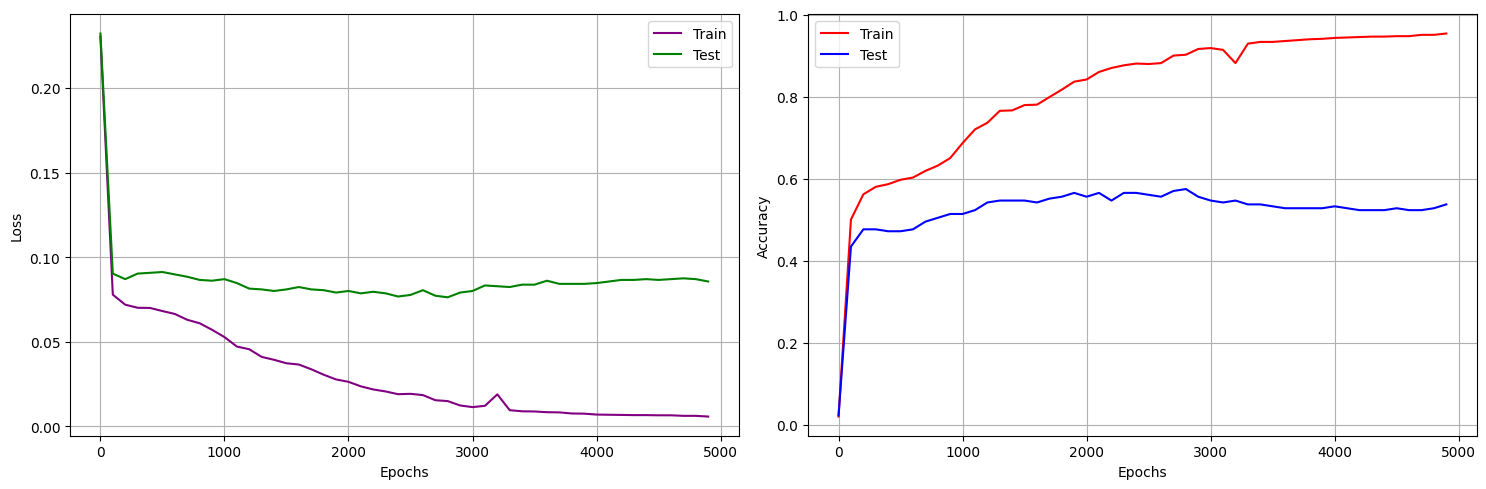

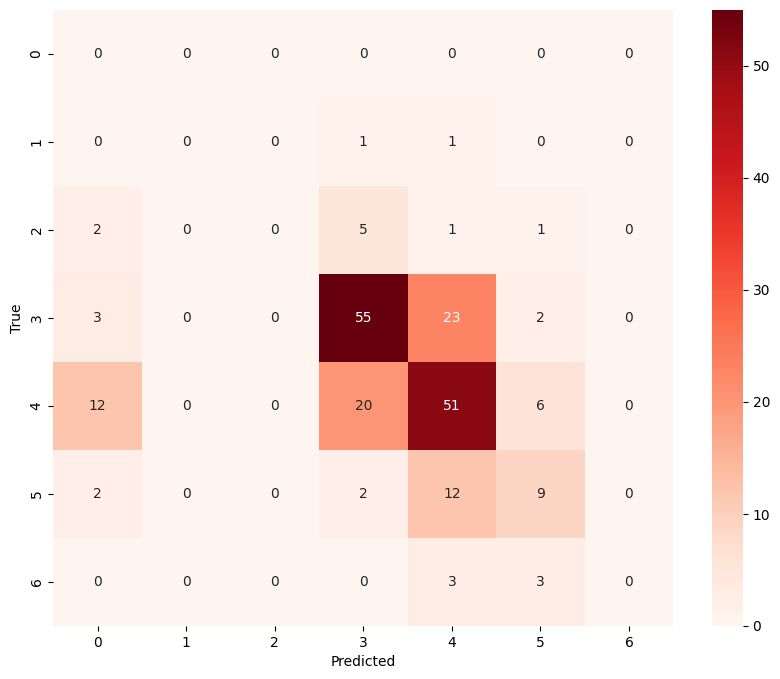

In [22]:
nn = MLP_tanh(11,[128, 64, 32] , 10)
learning_rate = .5
epochs = 5000
train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred = train_loop(nn, epochs, learning_rate)
print(f'Activation function: tanh')
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

class_report = classification_report(y_true, y_pred)
print('Classification Report:')
print(class_report)
plot_results(train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred)


In [23]:

class MLP_relu:
    def __init__(self, input_size, hidden_layer_sizes, output_size):
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_layer_sizes) + 1
        self.weights = []
        self.biases = []
        input_layer_size = input_size
        for layer_size in hidden_layer_sizes:
            rand1 = np.random.randn(input_layer_size, layer_size) / 10
            self.weights.append(rand1)
            rand2 = np.random.randn(layer_size) / 10
            self.biases.append(rand2)
            input_layer_size = layer_size
        randw = np.random.randn(input_layer_size, output_size) / 10
        self.weights.append(randw)
        randb = np.random.randn(output_size) / 10
        self.biases.append(randb)

    def forward(self, X):
        activation = X
        self.activations = [activation]
        self.z_values = []

        for i in range(self.num_layers):
            z = np.dot(activation, self.weights[i]) + self.biases[i]
            if i == self.num_layers - 1:  
                activation = self.output_active_f(z)
            else: 
                activation = self.active_f(z)  
            self.z_values.append(z)
            self.activations.append(activation)

        return activation

    def active_f(self, x, alpha=0.01):
        return np.maximum(0, x)

    def active_f_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, 0)
    
    def output_active_f(self, x):
        return 1 / (1 + np.exp(-x))

    def output_active_f_derivative(self, x):
        return self.output_active_f(x) * (1 - self.output_active_f(x))
    
    def backward(self, X, y, learning_rate):
        num_samples = X.shape[0]
        d_weights = [np.zeros_like(w) for w in self.weights]
        d_biases = [np.zeros_like(b) for b in self.biases]
        
        output_error = self.activations[-1] - y
        delta = output_error * self.output_active_f_derivative(self.z_values[-1])
        
        d_weights[-1] = np.dot(self.activations[-2].T, delta)
        d_biases[-1] = np.sum(delta, axis=0)
        
        for l in range(2, self.num_layers + 1):
            delta = np.dot(delta, self.weights[-l+1].T) * self.active_f_derivative(self.z_values[-l])
            d_weights[-l] = np.dot(self.activations[-l-1].T, delta)
            d_biases[-l] = np.sum(delta, axis=0)
        
        self.weights = [w - (learning_rate / num_samples) * dw for w, dw in zip(self.weights, d_weights)]
        self.biases = [b - (learning_rate / num_samples) * db for b, db in zip(self.biases, d_biases)]

    def train(self, X, y, learning_rate):

        output = self.forward(X)

        self.backward(X, y, learning_rate)
        
    def predict(self, X):
        return np.round(self.forward(X)).astype(np.int32)


Epoch 0: Train Loss: 0.10, Train Accuracy: 0.00, Test Loss: 0.10, Test Accuracy: 0.00
Epoch 1000: Train Loss: 0.00, Train Accuracy: 0.98, Test Loss: 0.08, Test Accuracy: 0.56
Epoch 2000: Train Loss: 0.00, Train Accuracy: 0.98, Test Loss: 0.08, Test Accuracy: 0.57
Epoch 3000: Train Loss: 0.00, Train Accuracy: 0.98, Test Loss: 0.08, Test Accuracy: 0.56
Epoch 4000: Train Loss: 0.00, Train Accuracy: 0.98, Test Loss: 0.08, Test Accuracy: 0.56
Activation function: relu
Accuracy: 0.5561
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.66      0.65      0.65        83
         6.0       0.60      0.55      0.57        89
         7.0       0.55      0.64      0.59        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.56       214
   m

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

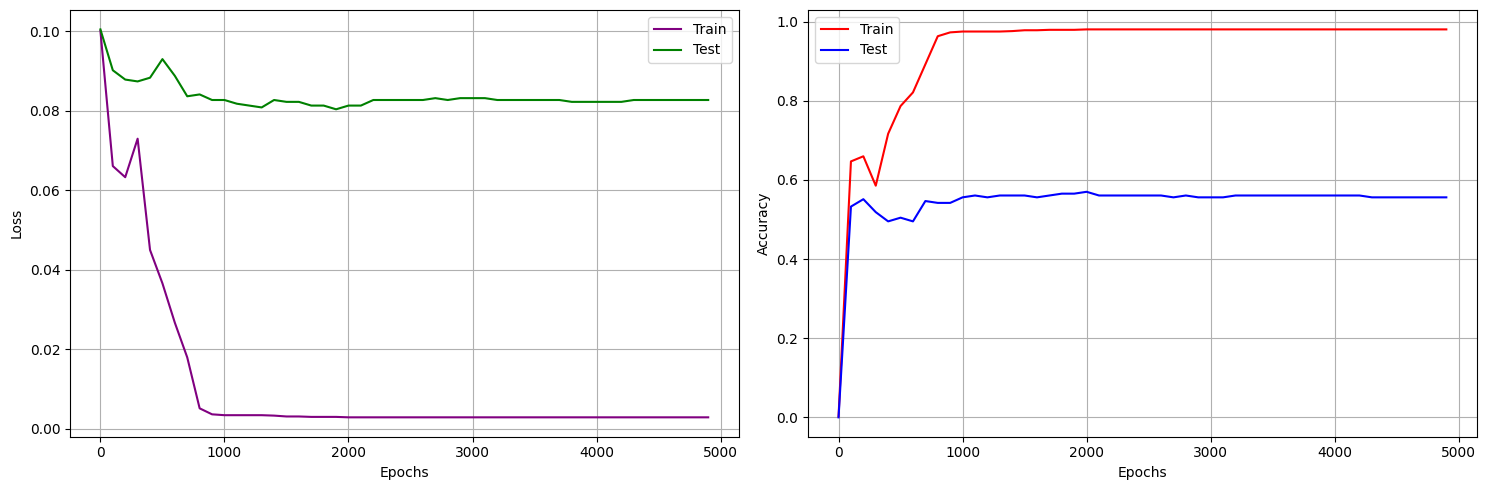

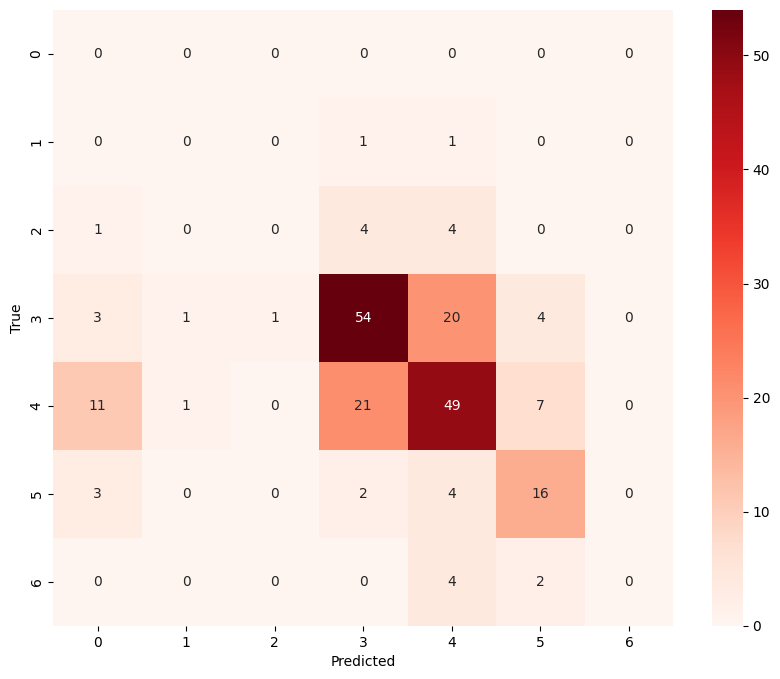

In [24]:
nn = MLP_relu(11,[32, 64, 32] , 10)
learning_rate = 5
epochs = 5000
train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred = train_loop(nn, epochs, learning_rate)
print(f'Activation function: relu')
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

class_report = classification_report(y_true, y_pred)
print('Classification Report:')
print(class_report)
plot_results(train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred)

In [25]:

class MLP_leakyrelu:
    def __init__(self, input_size, hidden_layer_sizes, output_size):
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_layer_sizes) + 1
        self.weights = []
        self.biases = []
        input_layer_size = input_size
        for layer_size in hidden_layer_sizes:
            rand1 = np.random.randn(input_layer_size, layer_size) / 10
            self.weights.append(rand1)
            rand2 = np.random.randn(layer_size) / 10
            self.biases.append(rand2)
            input_layer_size = layer_size
        randw = np.random.randn(input_layer_size, output_size) / 10
        self.weights.append(randw)
        randb = np.random.randn(output_size) / 10
        self.biases.append(randb)

    def forward(self, X):
        activation = X
        self.activations = [activation]
        self.z_values = []

        for i in range(self.num_layers):
            z = np.dot(activation, self.weights[i]) + self.biases[i]
            if i == self.num_layers - 1:  
                activation = self.output_active_f(z)
            else: 
                activation = self.active_f(z)  
            self.z_values.append(z)
            self.activations.append(activation)

        return activation

    def active_f(self, x, alpha=0.01):
        return np.where(x > 0, x, alpha * x)


    def active_f_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)
    
    def output_active_f(self, x):
        return 1 / (1 + np.exp(-x))

    def output_active_f_derivative(self, x):
        return self.output_active_f(x) * (1 - self.output_active_f(x))
    
    def backward(self, X, y, learning_rate):
        num_samples = X.shape[0]
        d_weights = [np.zeros_like(w) for w in self.weights]
        d_biases = [np.zeros_like(b) for b in self.biases]
        
        output_error = self.activations[-1] - y
        delta = output_error * self.output_active_f_derivative(self.z_values[-1])
        
        d_weights[-1] = np.dot(self.activations[-2].T, delta)
        d_biases[-1] = np.sum(delta, axis=0)
        
        for l in range(2, self.num_layers + 1):
            delta = np.dot(delta, self.weights[-l+1].T) * self.active_f_derivative(self.z_values[-l])
            d_weights[-l] = np.dot(self.activations[-l-1].T, delta)
            d_biases[-l] = np.sum(delta, axis=0)
        
        self.weights = [w - (learning_rate / num_samples) * dw for w, dw in zip(self.weights, d_weights)]
        self.biases = [b - (learning_rate / num_samples) * db for b, db in zip(self.biases, d_biases)]

    def train(self, X, y, learning_rate):

        output = self.forward(X)

        self.backward(X, y, learning_rate)
        
    def predict(self, X):
        return np.round(self.forward(X)).astype(np.int32)


Epoch 0: Train Loss: 0.19, Train Accuracy: 0.45, Test Loss: 0.19, Test Accuracy: 0.43
Epoch 1000: Train Loss: 0.05, Train Accuracy: 0.68, Test Loss: 0.09, Test Accuracy: 0.50
Epoch 2000: Train Loss: 0.04, Train Accuracy: 0.75, Test Loss: 0.09, Test Accuracy: 0.55
Epoch 3000: Train Loss: 0.04, Train Accuracy: 0.78, Test Loss: 0.09, Test Accuracy: 0.53
Epoch 4000: Train Loss: 0.02, Train Accuracy: 0.85, Test Loss: 0.09, Test Accuracy: 0.52
Activation function: leaky relu
Accuracy: 0.5234
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.69      0.51      0.58        83
         6.0       0.53      0.67      0.59        89
         7.0       0.48      0.40      0.43        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.52       21

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

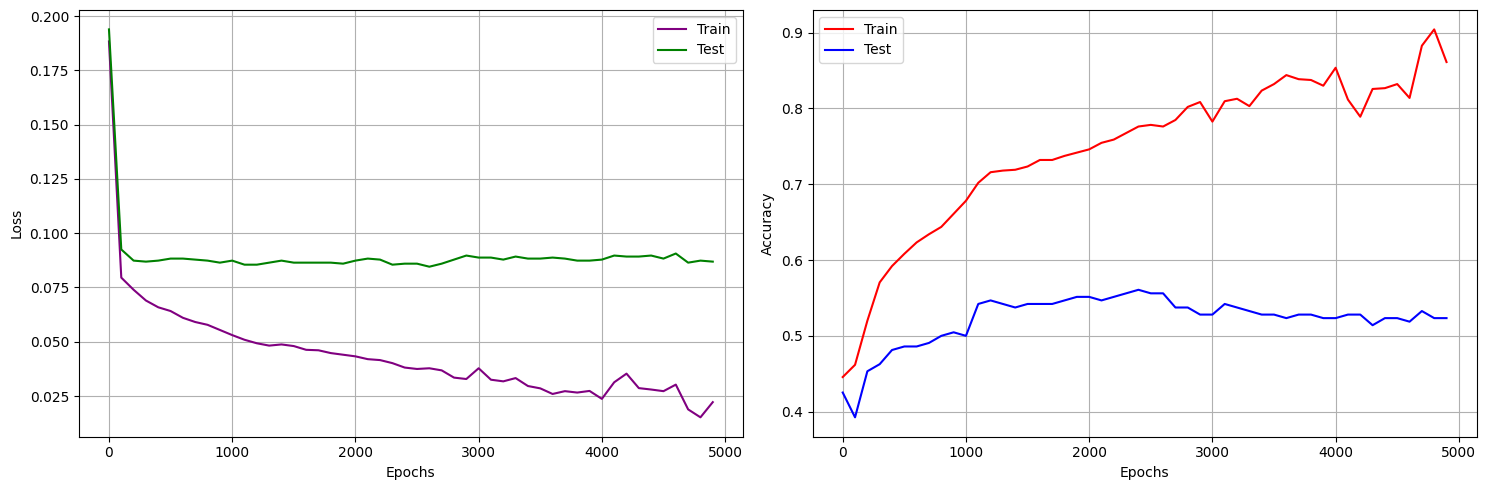

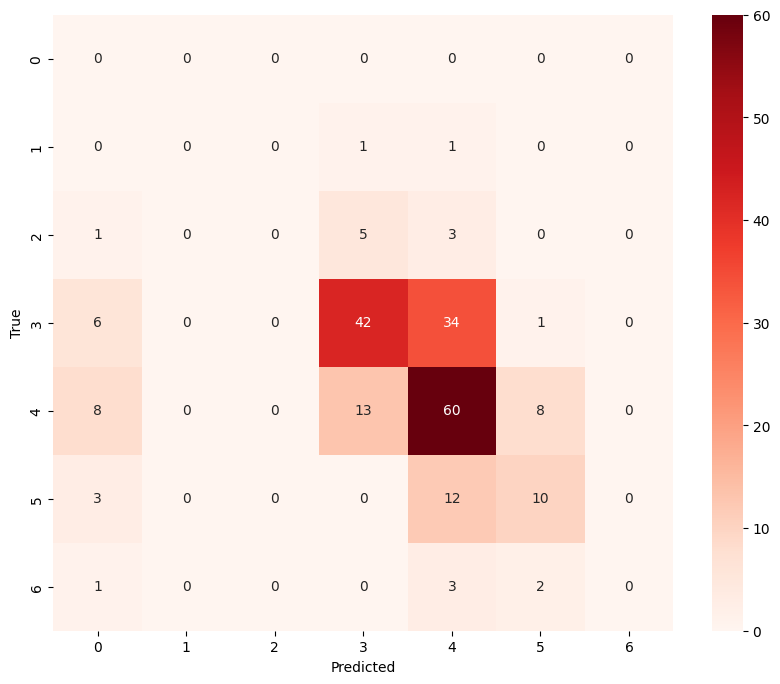

In [26]:
nn = MLP_leakyrelu(11,[64, 32] , 10)
learning_rate = 0.5
epochs = 5000
train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred = train_loop(nn, epochs, learning_rate)
print(f'Activation function: leaky relu')
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

class_report = classification_report(y_true, y_pred)
print('Classification Report:')
print(class_report)
plot_results(train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred)


In [27]:

class MLP_elu:
    def __init__(self, input_size, hidden_layer_sizes, output_size):
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_layer_sizes) + 1
        self.weights = []
        self.biases = []
        input_layer_size = input_size
        for layer_size in hidden_layer_sizes:
            rand1 = np.random.randn(input_layer_size, layer_size) / 10
            self.weights.append(rand1)
            rand2 = np.random.randn(layer_size) / 10
            self.biases.append(rand2)
            input_layer_size = layer_size
        randw = np.random.randn(input_layer_size, output_size) / 10
        self.weights.append(randw)
        randb = np.random.randn(output_size) / 10
        self.biases.append(randb)

    def forward(self, X):
        activation = X
        self.activations = [activation]
        self.z_values = []

        for i in range(self.num_layers):
            z = np.dot(activation, self.weights[i]) + self.biases[i]
            if i == self.num_layers - 1:  
                activation = self.output_active_f(z)
            else: 
                activation = self.active_f(z)  
            self.z_values.append(z)
            self.activations.append(activation)

        return activation

    def active_f(self, x, alpha=0.01):
        return np.where(x > 0, x, alpha * (np.exp(x) - 1))

    def active_f_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha * np.exp(x))
    
    def output_active_f(self, x):
        return 1 / (1 + np.exp(-x))

    def output_active_f_derivative(self, x):
        return self.output_active_f(x) * (1 - self.output_active_f(x))
    
    def backward(self, X, y, learning_rate):
        num_samples = X.shape[0]
        d_weights = [np.zeros_like(w) for w in self.weights]
        d_biases = [np.zeros_like(b) for b in self.biases]
        
        output_error = self.activations[-1] - y
        delta = output_error * self.output_active_f_derivative(self.z_values[-1])
        
        d_weights[-1] = np.dot(self.activations[-2].T, delta)
        d_biases[-1] = np.sum(delta, axis=0)
        
        
        for l in range(2, self.num_layers + 1):
            delta = np.dot(delta, self.weights[-l+1].T) * self.active_f_derivative(self.z_values[-l])
            d_weights[-l] = np.dot(self.activations[-l-1].T, delta)
            d_biases[-l] = np.sum(delta, axis=0)
        
        self.weights = [w - (learning_rate / num_samples) * dw for w, dw in zip(self.weights, d_weights)]
        self.biases = [b - (learning_rate / num_samples) * db for b, db in zip(self.biases, d_biases)]

    def train(self, X, y, learning_rate):

        output = self.forward(X)

        self.backward(X, y, learning_rate)
        
    def predict(self, X):
        return np.round(self.forward(X)).astype(np.int32)


Epoch 0: Train Loss: 0.10, Train Accuracy: 0.41, Test Loss: 0.11, Test Accuracy: 0.38
Epoch 1000: Train Loss: 0.00, Train Accuracy: 0.98, Test Loss: 0.09, Test Accuracy: 0.50
Epoch 2000: Train Loss: 0.00, Train Accuracy: 0.98, Test Loss: 0.09, Test Accuracy: 0.51
Epoch 3000: Train Loss: 0.00, Train Accuracy: 0.98, Test Loss: 0.09, Test Accuracy: 0.50
Epoch 4000: Train Loss: 0.00, Train Accuracy: 0.99, Test Loss: 0.09, Test Accuracy: 0.50
Activation function: elu
Accuracy: 0.5047
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         2
         4.0       0.25      0.11      0.15         9
         5.0       0.57      0.52      0.54        83
         6.0       0.53      0.54      0.53        89
         7.0       0.59      0.64      0.62        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.50       214
   ma

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

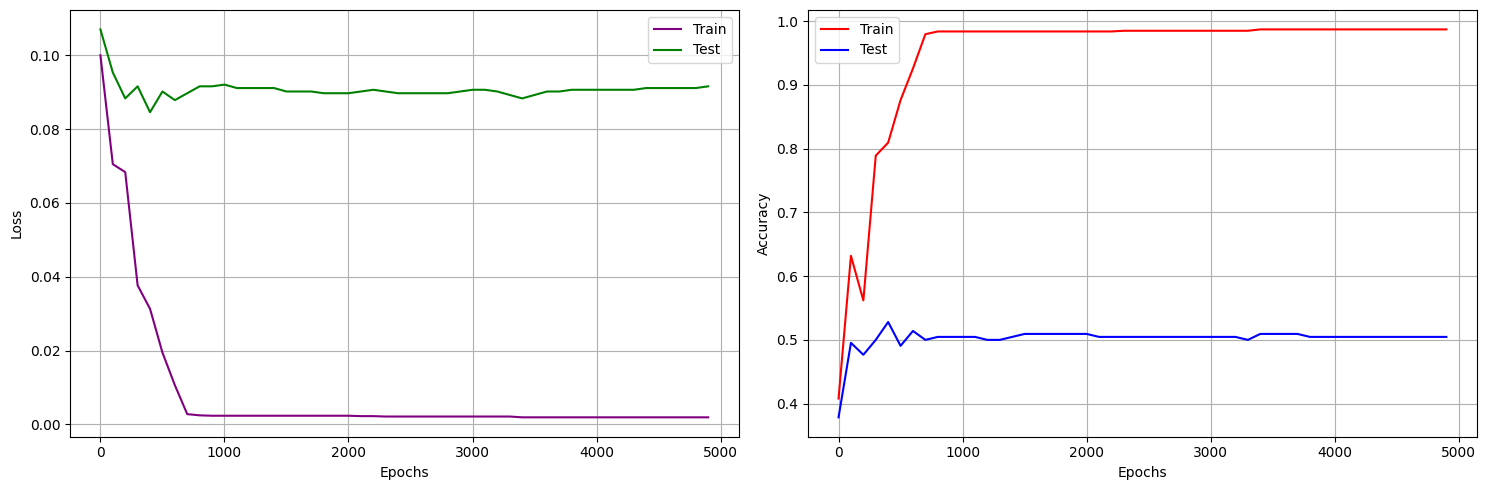

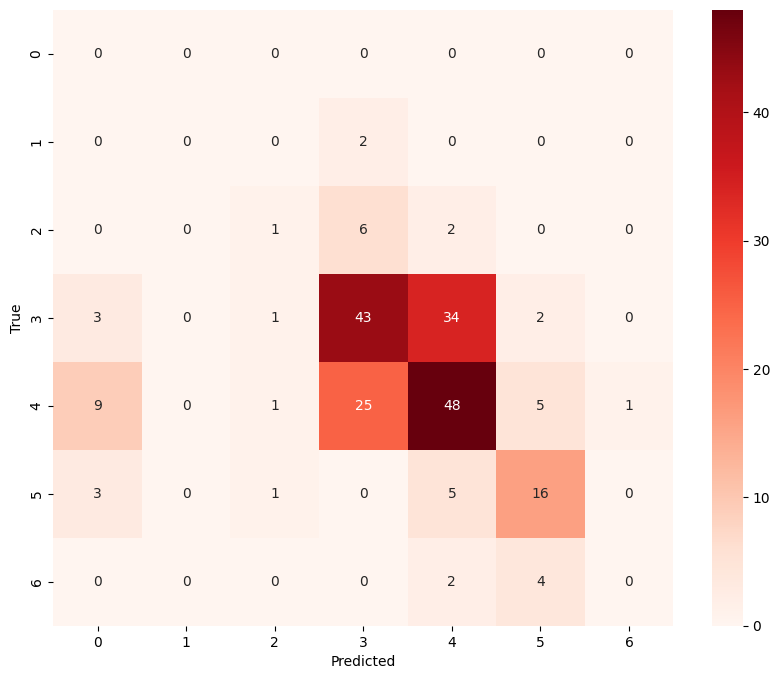

In [28]:
nn = MLP_elu(11,[128, 64, 32] , 10)
learning_rate = 5
epochs = 5000
train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred = train_loop(nn, epochs, learning_rate)
print(f'Activation function: elu')
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

class_report = classification_report(y_true, y_pred)
print('Classification Report:')
print(class_report)
plot_results(train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred)


In [29]:
class MLP_Rational:
    def __init__(self, input_size, hidden_layer_sizes, output_size):
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_layer_sizes) + 1
        self.weights = []
        self.biases = []
        input_layer_size = input_size
        for layer_size in hidden_layer_sizes:
            rand1 = np.random.randn(input_layer_size, layer_size)
            self.weights.append(rand1)
            rand2 = np.random.randn(layer_size)
            self.biases.append(rand2)
            input_layer_size = layer_size
        randw = np.random.randn(input_layer_size, output_size)
        self.weights.append(randw)
        randb = np.random.randn(output_size)
        self.biases.append(randb)

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        activation = X
        for i in range(self.num_layers):
            temp = np.dot(activation, self.weights[i]) + self.biases[i]
            activation = self.activ_f(temp)
            self.z_values.append(temp)
            self.activations.append(activation)

        return activation

    def activ_f(self, x, alpha=1.0):
        return x / (1 + np.sqrt(1 + x**2))



    def activ_f_derivative(self, x, alpha=1.0):
        return 1 / (1 + np.sqrt(1 + x**2))**2

    def backward(self, X, y, learning_rate):
        num_samples = X.shape[0]
        d_weights = [np.zeros_like(w) for w in self.weights]
        d_biases = [np.zeros_like(b) for b in self.biases]

        delta = (self.activations[-1] - y) * self.activ_f_derivative(self.z_values[-1])
        d_weights[-1] = np.dot(self.activations[-2].T, delta)
        d_biases[-1] = np.sum(delta, axis=0)

        for l in range(2, self.num_layers + 1):
            delta = np.dot(delta, self.weights[-l+1].T) * self.activ_f_derivative(self.z_values[-l])
            d_weights[-l] = np.dot(self.activations[-l-1].T, delta)
            d_biases[-l] = np.sum(delta, axis=0)

        self.weights = [w - (learning_rate / num_samples) * dw for w, dw in zip(self.weights, d_weights)]
        self.biases = [b - (learning_rate / num_samples) * db for b, db in zip(self.biases, d_biases)]

    def train(self, X, y, learning_rate):

        output = self.forward(X)

        self.backward(X, y, learning_rate)
        
    def predict(self, X):
        return np.round(self.forward(X)).astype(np.int32)


Epoch 0: Train Loss: 0.69, Train Accuracy: 0.12, Test Loss: 0.68, Test Accuracy: 0.11
Epoch 1000: Train Loss: 0.04, Train Accuracy: 0.71, Test Loss: 0.10, Test Accuracy: 0.42
Epoch 2000: Train Loss: 0.03, Train Accuracy: 0.80, Test Loss: 0.10, Test Accuracy: 0.50
Epoch 3000: Train Loss: 0.02, Train Accuracy: 0.85, Test Loss: 0.11, Test Accuracy: 0.54
Epoch 4000: Train Loss: 0.02, Train Accuracy: 0.88, Test Loss: 0.11, Test Accuracy: 0.54
Activation function: Rational
Accuracy: 0.5421
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.61      0.61      0.61        83
         6.0       0.54      0.61      0.57        89
         7.0       0.50      0.44      0.47        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.54       214


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

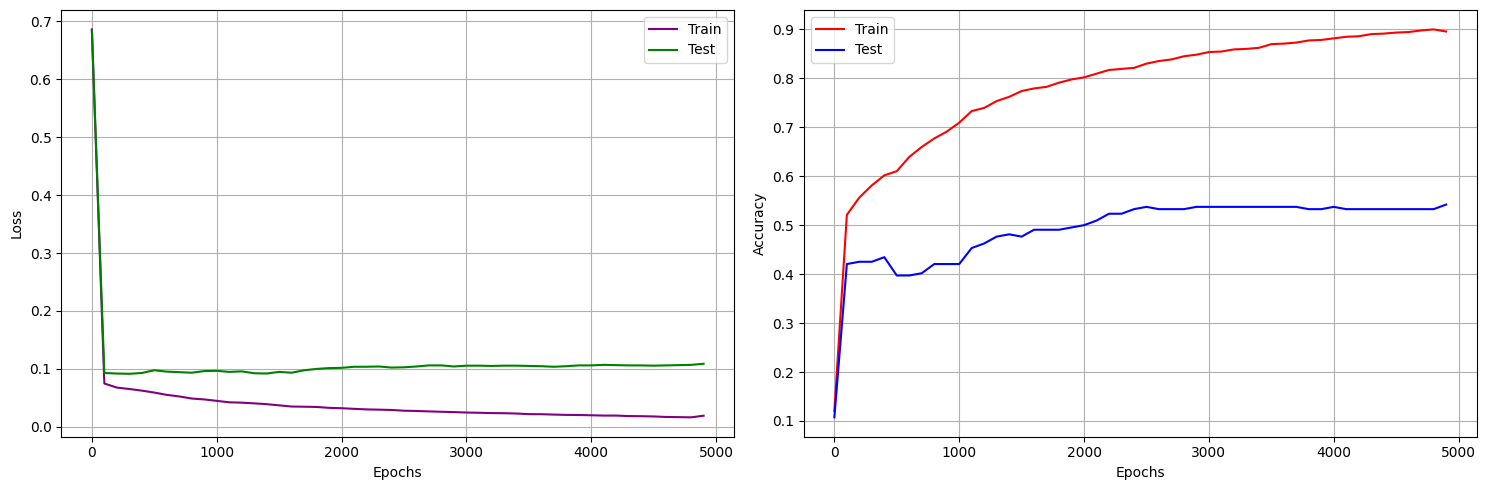

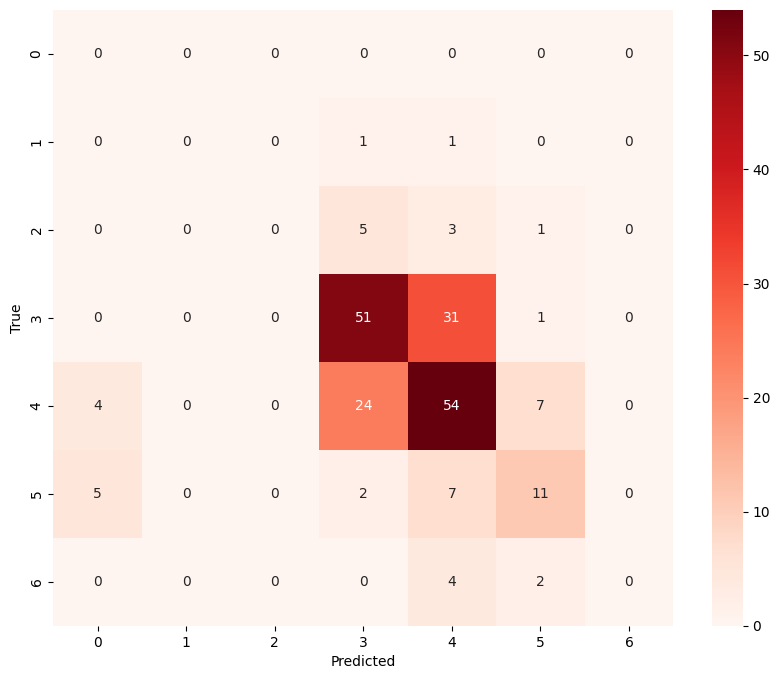

In [30]:
nn = MLP_Rational(11,[20, 50, 20] , 10)
learning_rate = 5
epochs = 5000
train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred = train_loop(nn, epochs, learning_rate)
print(f'Activation function: Rational')
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

class_report = classification_report(y_true, y_pred)
print('Classification Report:')
print(class_report)
plot_results(train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred)


In [49]:

class MLP_softmax:
    def __init__(self, input_size, hidden_layer_sizes, output_size):
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_layer_sizes) + 1
        self.weights = []
        self.biases = []
        input_layer_size = input_size
        for layer_size in hidden_layer_sizes:
            rand1 = np.random.randn(input_layer_size, layer_size)
            self.weights.append(rand1)
            rand2 = np.random.randn(layer_size)
            self.biases.append(rand2)
            input_layer_size = layer_size
        randw = np.random.randn(input_layer_size, output_size)
        self.weights.append(randw)
        randb = np.random.randn(output_size)
        self.biases.append(randb)

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        activation = X
        for i in range(self.num_layers):
            temp = np.dot(activation, self.weights[i]) + self.biases[i]
            activation = self.activ_f(temp)
            self.z_values.append(temp)
            self.activations.append(activation)

        return activation

    def activ_f(self, x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

    def activ_f_derivative(self, x, alpha=1.0):
        s = self.softmax(x)
        return s * (1 - s)

    def backward(self, X, y, learning_rate):
        num_samples = X.shape[0]
        d_weights = [np.zeros_like(w) for w in self.weights]
        d_biases = [np.zeros_like(b) for b in self.biases]

        delta = (self.activations[-1] - y) * self.activ_f_derivative(self.z_values[-1])
        d_weights[-1] = np.dot(self.activations[-2].T, delta)
        d_biases[-1] = np.sum(delta, axis=0)

        for l in range(2, self.num_layers + 1):
            delta = np.dot(delta, self.weights[-l+1].T) * self.activ_f_derivative(self.z_values[-l])
            d_weights[-l] = np.dot(self.activations[-l-1].T, delta)
            d_biases[-l] = np.sum(delta, axis=0)

        self.weights = [w - (learning_rate / num_samples) * dw for w, dw in zip(self.weights, d_weights)]
        self.biases = [b - (learning_rate / num_samples) * db for b, db in zip(self.biases, d_biases)]

    def train(self, X, y, learning_rate):

        output = self.forward(X)

        self.backward(X, y, learning_rate)
        
    def predict(self, X):
        return np.round(self.forward(X)).astype(np.int32)


Epoch 0: Train Loss: 0.10, Train Accuracy: 0.00, Test Loss: 0.10, Test Accuracy: 0.00
Epoch 1000: Train Loss: 0.08, Train Accuracy: 0.48, Test Loss: 0.09, Test Accuracy: 0.40
Epoch 2000: Train Loss: 0.08, Train Accuracy: 0.49, Test Loss: 0.09, Test Accuracy: 0.41
Epoch 3000: Train Loss: 0.07, Train Accuracy: 0.49, Test Loss: 0.08, Test Accuracy: 0.44
Epoch 4000: Train Loss: 0.08, Train Accuracy: 0.52, Test Loss: 0.09, Test Accuracy: 0.42
Activation function: softmax
Accuracy: 0.5074
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         7
         5.0       0.62      0.59      0.60        76
         6.0       0.54      0.62      0.58        93
         7.0       0.00      0.00      0.00        23
         8.0       0.00      0.00      0.00         4

    accuracy                           0.51       203
   macro avg       0.19      0.20      0.20       203
w

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

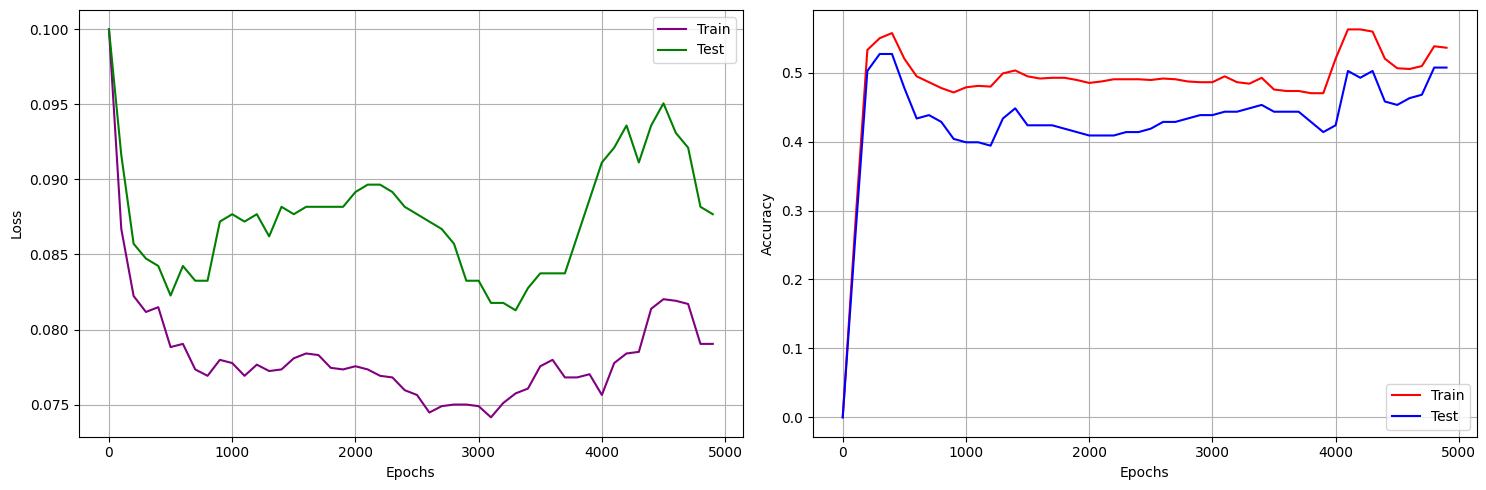

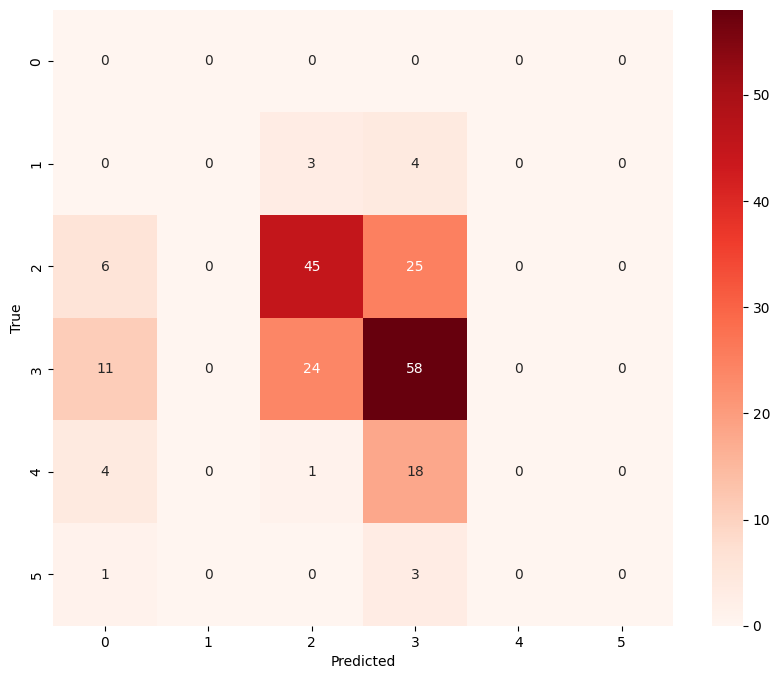

In [50]:
nn = MLP_softmax(11,[20, 50, 20] , 10)
learning_rate = 5
epochs = 5000
train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred = train_loop(nn, epochs, learning_rate)
print(f'Activation function: softmax')
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

class_report = classification_report(y_true, y_pred)
print('Classification Report:')
print(class_report)
plot_results(train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred)


In [31]:

class MLP_swish:
    def __init__(self, input_size, hidden_layer_sizes, output_size):
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_layer_sizes) + 1
        self.weights = []
        self.biases = []
        input_layer_size = input_size
        for layer_size in hidden_layer_sizes:
            rand1 = np.random.randn(input_layer_size, layer_size) / 10
            self.weights.append(rand1)
            rand2 = np.random.randn(layer_size) / 10
            self.biases.append(rand2)
            input_layer_size = layer_size
        randw = np.random.randn(input_layer_size, output_size) / 10
        self.weights.append(randw)
        randb = np.random.randn(output_size) / 10
        self.biases.append(randb)

    def forward(self, X):
        activation = X
        self.activations = [activation]
        self.z_values = []

        for i in range(self.num_layers):
            z = np.dot(activation, self.weights[i]) + self.biases[i]
            if i == self.num_layers - 1:  
                activation = self.output_active_f(z)
            else: 
                activation = self.active_f(z)  
            self.z_values.append(z)
            self.activations.append(activation)

        return activation
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def active_f(self, x, alpha=0.01):
        return x * self.sigmoid(x)

    def active_f_derivative(self, x, alpha=0.01):
        return self.active_f(x) + self.sigmoid(x) * (1 - self.active_f(x))
    
    def output_active_f(self, x):
        return 1 / (1 + np.exp(-x))

    def output_active_f_derivative(self, x):
        return self.output_active_f(x) * (1 - self.output_active_f(x))
    
    def backward(self, X, y, learning_rate):
        num_samples = X.shape[0]
        d_weights = [np.zeros_like(w) for w in self.weights]
        d_biases = [np.zeros_like(b) for b in self.biases]
        
        output_error = self.activations[-1] - y
        delta = output_error * self.output_active_f_derivative(self.z_values[-1])
        
        d_weights[-1] = np.dot(self.activations[-2].T, delta)
        d_biases[-1] = np.sum(delta, axis=0)
        
        
        for l in range(2, self.num_layers + 1):
            delta = np.dot(delta, self.weights[-l+1].T) * self.active_f_derivative(self.z_values[-l])
            d_weights[-l] = np.dot(self.activations[-l-1].T, delta)
            d_biases[-l] = np.sum(delta, axis=0)
        
        self.weights = [w - (learning_rate / num_samples) * dw for w, dw in zip(self.weights, d_weights)]
        self.biases = [b - (learning_rate / num_samples) * db for b, db in zip(self.biases, d_biases)]

    def train(self, X, y, learning_rate):

        output = self.forward(X)

        self.backward(X, y, learning_rate)
        
    def predict(self, X):
        return np.round(self.forward(X)).astype(np.int32)


Epoch 0: Train Loss: 0.12, Train Accuracy: 0.45, Test Loss: 0.12, Test Accuracy: 0.41
Epoch 1000: Train Loss: 0.06, Train Accuracy: 0.64, Test Loss: 0.09, Test Accuracy: 0.51
Epoch 2000: Train Loss: 0.05, Train Accuracy: 0.67, Test Loss: 0.09, Test Accuracy: 0.50
Epoch 3000: Train Loss: 0.04, Train Accuracy: 0.78, Test Loss: 0.09, Test Accuracy: 0.53
Epoch 4000: Train Loss: 0.02, Train Accuracy: 0.87, Test Loss: 0.09, Test Accuracy: 0.52
Activation function: swish
Accuracy: 0.5421
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.60      0.63      0.62        83
         6.0       0.58      0.60      0.59        89
         7.0       0.46      0.44      0.45        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.54       214
   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

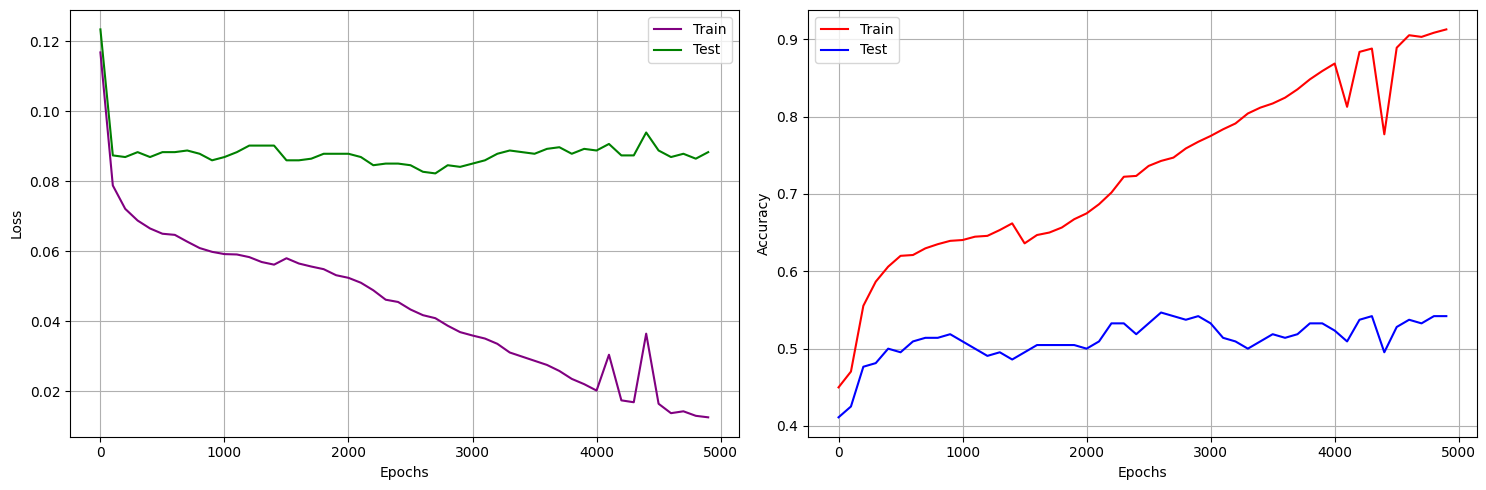

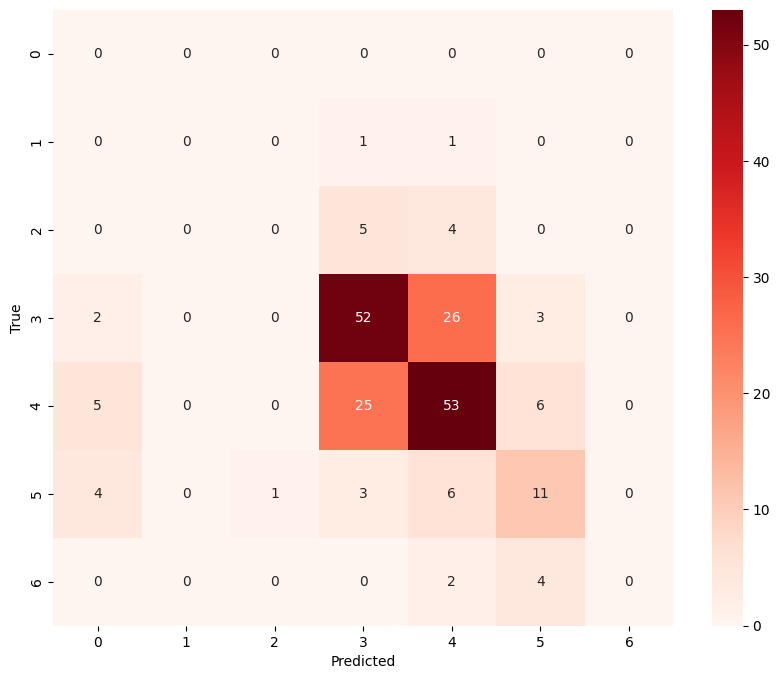

In [32]:
nn = MLP_swish(11,[64, 32] , 10)
learning_rate = 1
epochs = 5000
train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred = train_loop(nn, epochs, learning_rate)
print(f'Activation function: swish')
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

class_report = classification_report(y_true, y_pred)
print('Classification Report:')
print(class_report)
plot_results(train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred)


In [33]:

class MLP_softplus:
    def __init__(self, input_size, hidden_layer_sizes, output_size):
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_layer_sizes) + 1
        self.weights = []
        self.biases = []
        input_layer_size = input_size
        for layer_size in hidden_layer_sizes:
            rand1 = np.random.randn(input_layer_size, layer_size) / 10
            self.weights.append(rand1)
            rand2 = np.random.randn(layer_size) / 10
            self.biases.append(rand2)
            input_layer_size = layer_size
        randw = np.random.randn(input_layer_size, output_size) / 10
        self.weights.append(randw)
        randb = np.random.randn(output_size) / 10
        self.biases.append(randb)

    def forward(self, X):
        activation = X
        self.activations = [activation]
        self.z_values = []

        for i in range(self.num_layers):
            z = np.dot(activation, self.weights[i]) + self.biases[i]
            if i == self.num_layers - 1:  
                activation = self.output_active_f(z)
            else: 
                activation = self.active_f(z)  
            self.z_values.append(z)
            self.activations.append(activation)

        return activation
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def active_f(self, x, alpha=0.01):
        return np.log(1 + np.exp(x))

    def active_f_derivative(self, x, alpha=0.01):
        return self.active_f(x) + self.sigmoid(x) * (1 - self.active_f(x))
    
    def output_active_f(self, x):
        return 1 / (1 + np.exp(-x))

    def output_active_f_derivative(self, x):
        return 1 / (1 + np.exp(-x))
    
    def backward(self, X, y, learning_rate):
        num_samples = X.shape[0]
        d_weights = [np.zeros_like(w) for w in self.weights]
        d_biases = [np.zeros_like(b) for b in self.biases]
        
        output_error = self.activations[-1] - y
        delta = output_error * self.output_active_f_derivative(self.z_values[-1])
        
        d_weights[-1] = np.dot(self.activations[-2].T, delta)
        d_biases[-1] = np.sum(delta, axis=0)
        
        
        for l in range(2, self.num_layers + 1):
            delta = np.dot(delta, self.weights[-l+1].T) * self.active_f_derivative(self.z_values[-l])
            d_weights[-l] = np.dot(self.activations[-l-1].T, delta)
            d_biases[-l] = np.sum(delta, axis=0)
        
        self.weights = [w - (learning_rate / num_samples) * dw for w, dw in zip(self.weights, d_weights)]
        self.biases = [b - (learning_rate / num_samples) * db for b, db in zip(self.biases, d_biases)]

    def train(self, X, y, learning_rate):

        output = self.forward(X)

        self.backward(X, y, learning_rate)
        
    def predict(self, X):
        return np.round(self.forward(X)).astype(np.int32)


Epoch 0: Train Loss: 0.10, Train Accuracy: 0.00, Test Loss: 0.10, Test Accuracy: 0.00
Epoch 1000: Train Loss: 0.06, Train Accuracy: 0.64, Test Loss: 0.09, Test Accuracy: 0.49
Epoch 2000: Train Loss: 0.05, Train Accuracy: 0.73, Test Loss: 0.09, Test Accuracy: 0.51
Epoch 3000: Train Loss: 0.06, Train Accuracy: 0.52, Test Loss: 0.09, Test Accuracy: 0.36
Epoch 4000: Train Loss: 0.02, Train Accuracy: 0.84, Test Loss: 0.09, Test Accuracy: 0.49
Activation function: swish
Accuracy: 0.4907
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         9
         5.0       0.65      0.54      0.59        83
         6.0       0.58      0.52      0.55        89
         7.0       0.47      0.56      0.51        25
         8.0       0.00      0.00      0.00         6

    accuracy                           0.49       214
   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

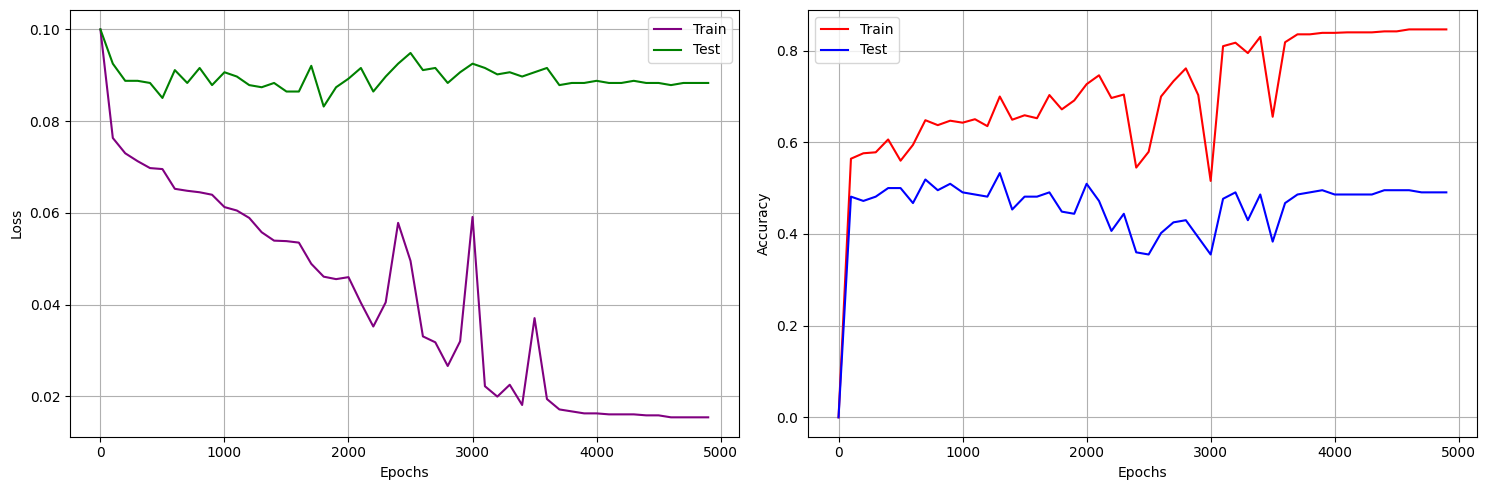

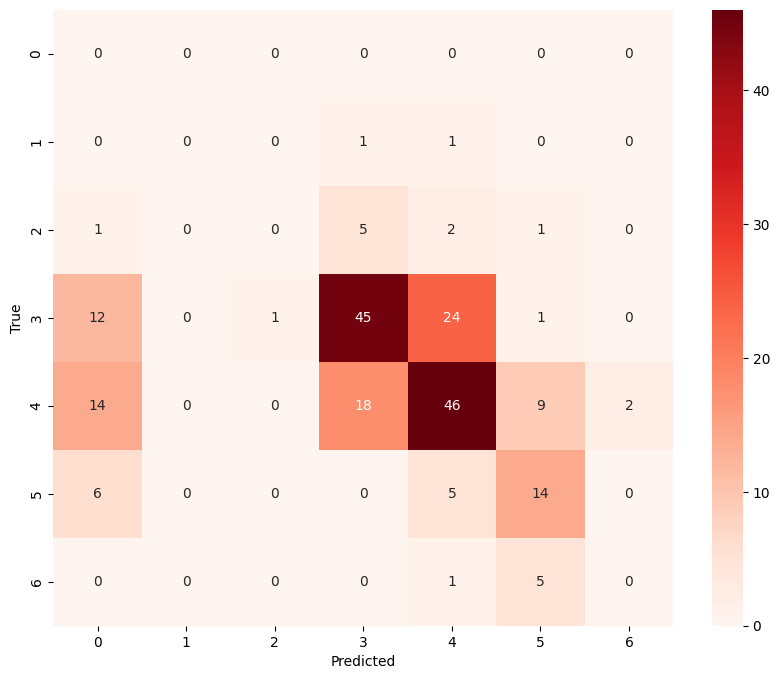

In [34]:
nn = MLP_softplus(11,[64, 32] , 10)
learning_rate = 1
epochs = 5000
train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred = train_loop(nn, epochs, learning_rate)
print(f'Activation function: swish')
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

class_report = classification_report(y_true, y_pred)
print('Classification Report:')
print(class_report)
plot_results(train_losses, train_accuracies, test_losses, test_accuracies, y_true, y_pred)
